In [109]:
%load_ext autoreload
%autoreload 2

In [129]:
C96hAEL = '#F9F06C'
C120hAEL = '#EBA434'
Cupcrawling = '#414042'
CwhitePupa = '#003399'
C2hAPF = '#0080FF'
C4hAPF = '#33FFFF'
C6hAPF = '#71C382'
CecadGFPnbG4 = '#404040'
CecadGFPnbG4myoVI = '#0099CC'


colors = {'ecadGFPnbG4': CecadGFPnbG4,
 'ecadGFPnbG4myoVI': CecadGFPnbG4myoVI,
          '96hAEL': C96hAEL,
          '120hAEL':C120hAEL,
 'wL3': Cupcrawling,
 '0hAPF': CwhitePupa,
 '2hAPF': C2hAPF,
 '4hAPF': C4hAPF,
 '6hAPF': C6hAPF}

color_dict = {'ecadGFPnbG4': CecadGFPnbG4,
 'ecadGFPnbG4myoVI': CecadGFPnbG4myoVI,
          '96hAEL': C96hAEL,
          '120hAEL':C120hAEL,
 'wL3': Cupcrawling,
 '0hAPF': CwhitePupa,
 '2hAPF': C2hAPF,
 '4hAPF': C4hAPF,
 '6hAPF': C6hAPF}

devstage_map = {
                "96hAEL":"96hAEL",
                "120hAEL":"120hAEL",
                "upcrawling":"wL3",
                "whitePupa":"0hAPF",
                "2hAPF":"2hAPF",
                "4hAPF":"4hAPF",
                "6hAPF":"6hAPF",
               }

rois = ['outDV', 'DV']
devstages = ["wL3","0hAPF","2hAPF","4hAPF","6hAPF"]
columns = ['devstage', 'discName', 'region', 'k_dist', 
           'area','neighbour_number','elongation_tensor_norm_max', 
           'Qrr_geom_inPlane','countInBin', 'cumcount','Qrr_areaNormBin','k_dist_pathlength'
          ]

columns = ['devstage','disc', 'discName', 'region', 'k_dist', 'roi',
           'area','neighbour_number','elongation_tensor_norm_max', 
           'Qrr_geom_inPlane', 'Qphiphi', 'Qnn', 'Qrphi', 'Qrn', 'Qphin',
           'countInBin', 'cumcount',
           'k_dist_pathlength']

In [130]:
import os
import pwd
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot

# codeRepo = '/Users/fuhrmann/workspace/'
codeRepo = '/home/pol_dye/jafu232d/'
sys.path.insert(0, codeRepo + '/wdeversion_paper/CurvedTM')
#

# Load Curved Tissue Miner packages
import curvedtm
#sys.path.remove('/Users/fuhrmann/workspace/wdeversion_paper/CurvedTM/')
from curvedtm import Ntools 
from curvedtm import calculateQrr

## WT 

In [131]:
pathtoserver = '/Volumes/'
pathtoserver = '/home/pol_dye/jafu232d/groups/'
datapath_base = pathtoserver + '/pol_dye_drosophilawing/P-WDeversion/curvedTM/data/'
genotype = 'ecadGFPnbG4'
dataout =  pathtoserver + '/pol_dye_drosophilawing/P-WDeversion/curvedTM/plotting/PaperPlots/' 
datapath = os.path.join(datapath_base, genotype)
frameIdx = 0
exist = os.path.exists(dataout)
if not exist:
   os.makedirs(dataout)

In [132]:
plt.style.use(codeRepo +  '/wdeversion_paper/' + 'seaborn-custom-whitegrid.mplstyle')

In [133]:
with open(datapath_base + 'DFallDiscs' + 'limitcounts.pkl','rb') as f:
   df = pickle.load(f)
df = df[df['genotype'] == genotype]
df["devstage"] = [devstage_map[x] for x in df["devstage"].values]
df = df[columns]


In [134]:
groupby_cols = ['devstage', 'region', 'discName', 'k_dist']
#here we pool cells within a ring and calculate the mean
df_pool_k = df.groupby(groupby_cols).agg('mean').reset_index() 
#we offset k_dist values if the rings do not start with k_dits = 0
k_dist_offset = df.groupby(['discName']).k_dist.agg('min')#.reset_index().set_index('discName') #some discs can have k starting from non-zero value, so we offset them by the starting k
df_pool_k['k_dist'] = df_pool_k['k_dist'] - k_dist_offset[df_pool_k['discName'].values].values #offsetting k values


#scale pathlength
pathlength_max = df_pool_k.groupby(['discName']).k_dist_pathlength.agg('max')
df_pool_k['pathlength_scaled'] = df_pool_k['k_dist_pathlength']/pathlength_max[df_pool_k['discName'].values].values
#compute Qnorm and exponential of Qnorm - to be used later
#function to compute area weighted average
wm = lambda x: np.average(x, weights=df.loc[x.index, "area"])

df_pool_areaWeighted_k = df.groupby(groupby_cols).agg(Qrr_geom_inPlane = pd.NamedAgg(column = 'Qrr_geom_inPlane', aggfunc = wm),
                                                      Qrphi = pd.NamedAgg(column = 'Qrphi', aggfunc = wm),
                                                      Qphiphi = pd.NamedAgg(column = 'Qphiphi', aggfunc = wm),
                                                     ).reset_index() 
df_pool_k[["Qrr_geom_inPlane", "Qrphi", "Qphiphi"]] = df_pool_areaWeighted_k[["Qrr_geom_inPlane", "Qrphi", "Qphiphi"]]

df_pool_k['Qnorm'] = np.sqrt(df_pool_k['Qrr_geom_inPlane']**2 + df_pool_k['Qrphi']**2)
df_pool_k['exp_signed_Qnorm'] = np.exp(np.sign(df_pool_k['Qrr_geom_inPlane'])*df_pool_k['Qnorm'])

/tmp/ipykernel_1412098/846196081.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pool_k = df.groupby(groupby_cols).agg('mean').reset_index()


In [135]:
groupby_cols = ['devstage', 'region', 'k_dist']
#here we pool discs within a devstage and calculate the mean and std
df_pool_devstage = df_pool_k.groupby(groupby_cols).agg(['mean', 'std']).reset_index()
colnames = [x[0]+'_'+x[1] if x[0] not in groupby_cols else x[0] for x in df_pool_devstage.columns]
df_pool_devstage.columns = colnames #removing multi-indexing

#compute Qnorm
df_pool_devstage['Qnorm_mean'] =  np.sqrt( df_pool_devstage['Qrr_geom_inPlane_mean']**2 + df_pool_devstage['Qrphi_mean']**2)#Norm of mean
df_pool_devstage['Qnorm_std'] = (df_pool_devstage['Qrr_geom_inPlane_mean']*df_pool_devstage['Qrr_geom_inPlane_std'] + df_pool_devstage['Qrphi_mean']*df_pool_devstage['Qrphi_std'])/df_pool_devstage['Qnorm_mean']

df_pool_devstage['exp_signed_Qnorm_mean'] = np.exp(np.sign(df_pool_devstage['Qrr_geom_inPlane_mean'])*df_pool_devstage['Qnorm_mean'])
df_pool_devstage['exp_signed_Qnorm_std'] = df_pool_devstage['exp_signed_Qnorm_mean']*df_pool_devstage['Qnorm_std']


/tmp/ipykernel_1412098/1143488363.py:3: FutureWarning: ['discName'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_pool_devstage = df_pool_k.groupby(groupby_cols).agg(['mean', 'std']).reset_index()


In [136]:
k_scaled_dist_dict = dict() #a dictionary for storing the polynomial object for fitting between fractional pathlength and N
devstage = "wL3"

from scipy.optimize import curve_fit
#for DV
roi = "DV"
query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
df_roi_stage = df_pool_devstage.query(query_str)
#doing a linear fit going through 0,0
def func(x, a):
    return a*x
popt, pcov = curve_fit(func, df_roi_stage['cumcount_mean'], df_roi_stage['pathlength_scaled_mean'])
p_DV_coeff = popt[0]
def p_DV(x):
    return(p_DV_coeff*x)
k_scaled_dist_dict[roi] = p_DV #coeffs[1] is supposed to be zero (very small value compared to 1 which is the max value of scaled dist)

#for outDV
roi = "outDV"
query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
df_roi_stage = df_pool_devstage.query(query_str)
#doing a linear fit going through 0,0
def func(x, a, b, c, d, e):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x
popt, pcov = curve_fit(func, df_roi_stage['cumcount_mean'], df_roi_stage['pathlength_scaled_mean'])
p_outDV_coeff = popt
def p_outDV(x):
    return p_outDV_coeff[0]*x**5 + p_outDV_coeff[1]*x**4 + p_outDV_coeff[2]*x**3 + p_outDV_coeff[3]*x**2 + p_outDV_coeff[4]*x
k_scaled_dist_dict[roi] = p_outDV #coeffs[1] is supposed to be zero (very small value compared to 1 which is the max value of scaled dist)

df_pool_k["ref_pathlength_scaled"] = df_pool_k.apply(lambda row: k_scaled_dist_dict[row['region']](row["cumcount"]),axis = 1)
df_pool_devstage["ref_pathlength_scaled"] = df_pool_devstage.apply(lambda row: k_scaled_dist_dict[row['region']](row['cumcount_mean']),axis = 1)

## plot over k

In [137]:

df_pool_k.loc[~(df_pool_k['Qrr_geom_inPlane']<2)]

,devstage,region,discName,k_dist,area,neighbour_number,elongation_tensor_norm_max,Qrr_geom_inPlane,Qphiphi,Qnn,Qrphi,Qrn,Qphin,countInBin,cumcount,k_dist_pathlength,pathlength_scaled,Qnorm,exp_signed_Qnorm,ref_pathlength_scaled


In [ ]:
''' 
prop is a point estimate of the mean per disc and k(interpolate), which is a reasonable approximation due to the large cell number
now find the precision of this measure across discs (x!=u)
and use a plug in estimate of the mean
'''

def draw_bs_sample(data):
    return np.random.choice(data, size=len(data), replace = True)
def draw_bs_reps(data, stats_method, size=1, args=() ):
    return np.array([stats_method(draw_bs_sample(data, *args)) for _ in range(size)])
    # stats_method is a placeholder for np.mean here
rois = ['DV','outDV']
prop  = 'Qrr_geom_inPlane'
# prop  = 'area'

stat_df_k = df_pool_k[['region','devstage','k_dist', prop]]

for roi in rois: 
    for d in range(len(devstages)):
        devstage = devstages[d]
        for k in range(0,stat_df_k['k_dist'].max()+1):

            # absolute values 
            datapoints = stat_df_k.loc[(stat_df_k['k_dist']==k)&(stat_df_k['devstage']==devstage)&(stat_df_k['region']==roi)][prop].values
            bs_reps = draw_bs_reps(datapoints, np.mean, size =10_000)
            conf_int = np.percentile(bs_reps,[2.5,97.5])
            stat_df_k.loc[(stat_df_k['k_dist']==k)&(stat_df_k['devstage']==devstage)&(stat_df_k['region']==roi),prop + '_plugInMean'] = np.mean(bs_reps)
            stat_df_k.loc[(stat_df_k['k_dist']==k)&(stat_df_k['devstage']==devstage)&(stat_df_k['region']==roi),prop + '_conf_int95'] = np.abs(conf_int[0]-conf_int[1])/2

stat_df_k = stat_df_k[['region','devstage','k_dist', prop + '_conf_int95', prop + '_plugInMean']].drop_duplicates()
#removing multi-indexing
#colnames = [x[0]+'_'+x[1] if x[1] != '' else x[0] for x in stat_df_k.columns]
#stat_df_k.columns = colnames 

outDV
DV


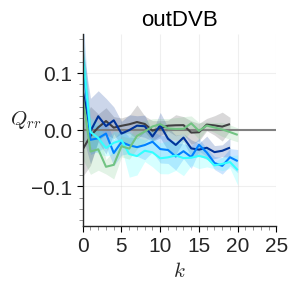

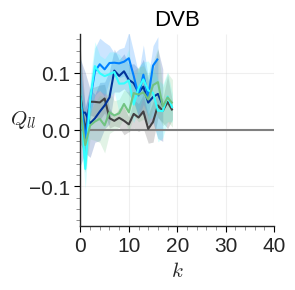

In [120]:
rois = ['outDV', 'DV']
x_axis = 'k_dist'
stats = '95CI'

devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[0:]})
for roi in rois:
    print(roi)
    fig,ax = plt.subplots(
                        figsize = (2.5,2.5))
    if roi == 'DV':
        xlimmax = 40
        ylimmax = 25
        # ax.set_xticks(ticks=np.arange(0,xlimmax+1, 5),labels = ['' if i % 10 else i for i in np.arange(0,xlimmax+1, 5)])
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_minor_locator(MultipleLocator(2))
        title =  'DVB'
                
    else:
        xlimmax = 25
        ylimmax = 20
        # ax.set_xticks(ticks=np.arange(0,xlimmax+1, 5),labels = ['' if i % 5 else i for i in np.arange(0,xlimmax+1, 5)])
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        title = 'outDVB'

    if prop == 'area':
        ylim = (3,ylimmax)
        ax.set_yticks(np.arange(5,26,5))
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.yaxis.set_minor_locator(MultipleLocator(1))
        ylabel= r'$A$'
    
        
    else:
        ylim=(-0.17,0.17)   
        ax.axhline(0, color ='grey')
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.02))
        if roi == 'DV':
            ylabel= r'$Q_{ll}$'
        else:
            ylabel= r'$Q_{rr}$'


    ax.set_xlim(0,xlimmax)  
    ax.set_ylim(ylim)   

    
    
    ax.tick_params(axis='both', which = 'major', color = 'black',length = 4)
    ax.tick_params(axis='both', which = 'minor', color = 'gray',length = 3)
    ax.grid(which = 'major', axis = 'both', alpha = 0.3)
   
    for j in range(len(devstages[0:])):
        devstage =  devstages[j]   
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
        
        data = stat_df_k.query(query_str)
    
        xlabel = x_axis
        xlabel = r'$k$'
        
        ax.fill_between(x = data[x_axis], y1 = data[prop + '_plugInMean'] - data[prop + '_conf_int95'], y2 = data[prop + '_plugInMean'] + data[prop + '_conf_int95'], color = colors[devstage], alpha = 0.2, linewidth = 0)
        ax.plot(data[x_axis], data[prop + '_plugInMean'],color = colors[devstage])
        # ax.errorbar(x = data[x_axis], y = data[prop + '_plugInMean'], yerr= data[prop + '_conf_int95'],color = colors[devstage],
        #     marker = '.', linestyle = '-')
        
    xlabel = r'$k$'
    ax.set_xlabel(xlabel, rotation = 'horizontal')
    ax.set_ylabel(ylabel, rotation = 'horizontal')
    ax.set_title(title)
    plt.savefig(dataout + genotype + prop + roi + '_k_dist_y95CI-eversion-xlim_max.pdf',dpi = 600,bbox_inches = 'tight')

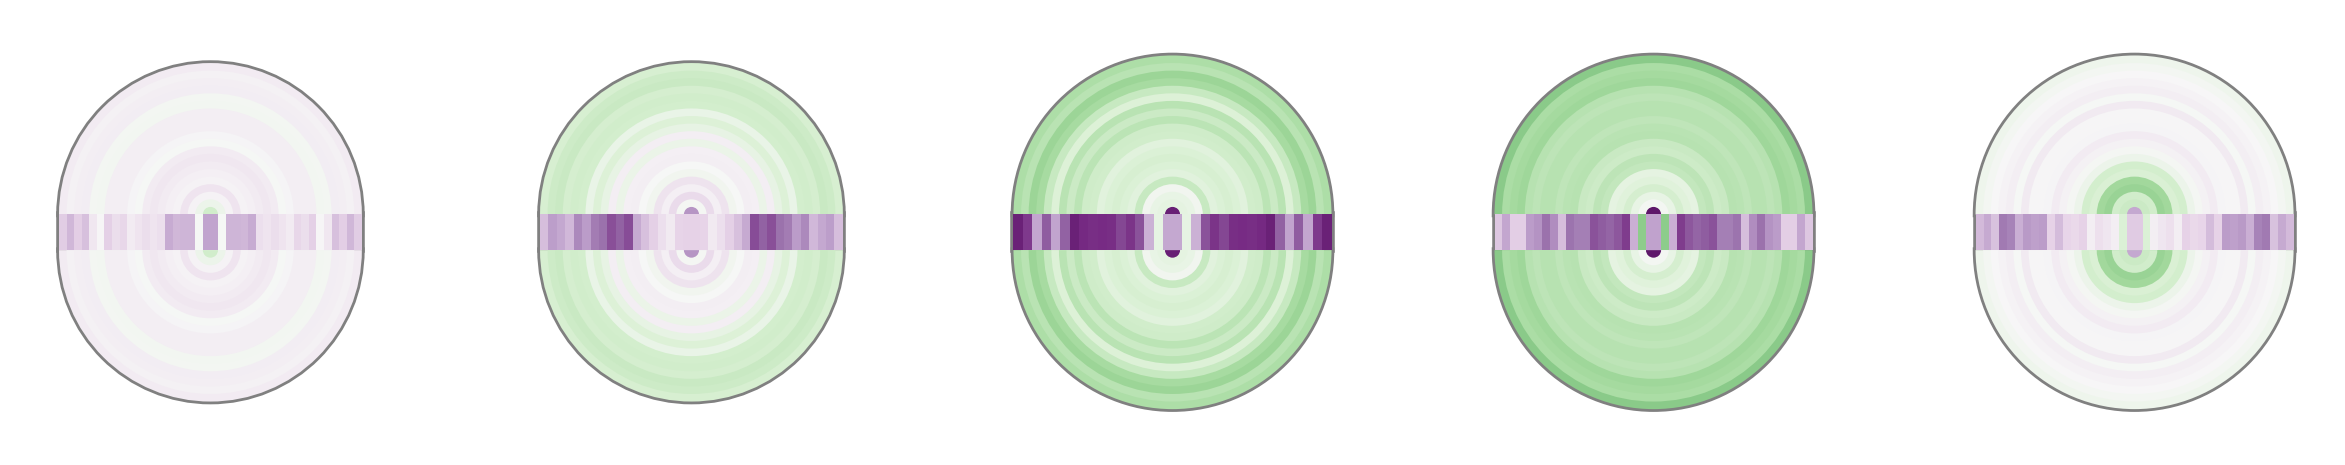

In [121]:
#Visualize Geometry
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm

############################ params
# cmap = cm.bwr
compareStepwise = False
fit = False

if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
    changes = 'stepwise'
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[0:]})
    changes = 'cumulative'


for i in range(1):

    if prop == 'area':
        cmap = cm.PuOr_r
        # cmap = cm.Oranges



    elif prop == 'exp_signed_Qnorm':
        cmap = cm.PRGn


    elif prop == 'Qrr_geom_inPlane':
        cmap = cm.PRGn_r


    prop2 = prop + '_plugInMean'


    fig, ax = plt.subplots(1,len(devstage_combinations),figsize=(30, 10))
    for j in range(len(devstages)):
        
        devstage = devstages[j]


        query_str = '(devstage == "' + devstage + '")'
        data = stat_df_k.query(query_str)
        #data[['k_beta','fit_exp_signed_Qnorm_diff','roi']]
        # data[['k_beta','exp_signed_Qnorm_diff_mean','roi']]
        data = data.sort_values(['k_dist'],ascending=False)

        values = data.loc[data['region']=='outDV'][prop2].values
        valuesDV = data.loc[data['region']=='DV'][prop2].values



        from matplotlib.collections import PatchCollection
        #ax.set_aspect('equal')

        patches1 = []
        patches2 = []
        patches3 = []
        patches4 = []
        angle = 0
        scaling = 0.017
        scalingDV = scaling*(len(values)/len(valuesDV))
        # scaling = 0.01
        theta1, theta2 = angle, angle + 180
        resolution = 100

        # climDVMin = climMin
        # climDVMax =  climMax

        if prop == 'area':

            climMin = values.mean() *0.5
            climMax = values.mean() *1.5

            climDVMin = valuesDV.mean() *0.5
            climDVMax = valuesDV.mean() *1.5
            # title = r'$cell' 'area$' + r'$\left(\frac{A}{\bar A}\right)$' 
            title = 'cell area ' + r'$\left(A / \bar A \right)$' 

        elif prop == 'exp_signed_Qnorm':
            climMin = 0.9
            climMax = 1.2

            climDVMin = climMin
            climDVMax =  climMax

        elif prop == 'Qrr_geom_inPlane':    
            climMin = -0.15
            climMax = 0.15
            title = 'cell elongation (' + r'$Q_{rr}$' + ',' + r'$Q_{ll}$' + ')'

            climDVMin = climMin
            climDVMax =  climMax


        for i in range(len(values),0,-1):
            radius= i*scaling
            w1 = Wedge((0, 0.04), radius, theta1, theta2, lw=2)
            for wedge in [w1]:
                patches1.append(wedge)
        p1 = PatchCollection(patches1, alpha=1, cmap=cmap)
        colorsDorsal = values
        p1.set_array(colorsDorsal)
        p1.set_clim([climMin, climMax])


        for i in range(len(values),0,-1):
            radius= i*scaling
            w2 = Wedge((0, -0.04), radius, theta2, theta1, lw=2)
            for wedge in [w2]:
                patches2.append(wedge)
        p2 = PatchCollection(patches2, alpha=1, cmap=cmap)
        colorsVentral = values
        p2.set_array(colorsVentral)
        p2.set_clim([climMin, climMax])
        
        for i in range(len(valuesDV),0,-1):
            positionX = 0
            polygon = Rectangle((positionX, -0.04), width=scalingDV*i, height=0.08, angle=0.0) 
            patches3.append(polygon)
            p3 = PatchCollection(patches3, cmap=cmap, ec = 'grey', linewidth = 0)
            colorsDV = valuesDV
            p3.set_array(colorsDV)
            p3.set_clim([climDVMin, climDVMax])
            
        for i in range(len(valuesDV),0,-1):
            positionX = -(i*scalingDV)
            polygon = Rectangle((positionX, -0.04), width=scalingDV, height=0.08, angle=0.0) 
            patches4.append(polygon)
            p4 = PatchCollection(patches4, cmap=cmap, ec = 'grey', linewidth = 0)
            colorsDV = valuesDV
            p4.set_array(colorsDV)
            p4.set_clim([climDVMin, climDVMax])
        col = j 
        ax[col].set_aspect('equal')
        p5 = Rectangle((-len(values)*scaling,-0.04), width=len(values)*scaling*2, height=0.08, angle=0.0, linewidth=4, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p5)
        p6 = Wedge((0,+0.04),len(values)*scaling, theta1, theta2,  linewidth=4, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p6)
        p7 = Wedge((0,-0.04),len(values)*scaling, theta2, theta1,  linewidth=4, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p7)

        
        ax[col].add_collection(p1)
        ax[col].add_collection(p2)
        ax[col].add_collection(p3)
        ax[col].add_collection(p4)

        ax[col].set_xlim(-0.45,0.45)
        ax[col].set_ylim(-0.5,0.5)
        ax[col].set_axis_off()

        # main_ax = fig.add_subplot(111, frameon=False)
        # main_ax.set_title(title, size = 80, fontweight = 'light')
        # main_ax.set_axis_off()

    plt.savefig(dataout + genotype + '_' + prop2 + '_' + '_geometry_all_over_k_dist'+ '.pdf',dpi = 300,bbox_inches = 'tight')


## Pathlength analysis

As we will use $N$(cumcount) to track regions between discs, we want to fit a polynomial to get the mapping between N and the reference scaled pathlength($p$).
The scaled pathlength $p$ is a dimensionless coordinate for the distance from the $k = 0$ location.
In the previous cells we already computed $p$ as $\text{k_dist_pathlength}/\max(\text{k_dist_pathlength})$ for each discName.

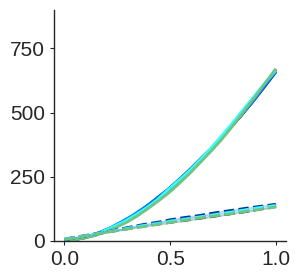

In [122]:
nbcols = 1
nbrows = 1

fig,ax = plt.subplots(nbrows, nbcols,
                       figsize = (3, 3)
                      )
for i in [0,1]:
    roi = rois[i]   
    if roi == 'DV':
        linestyle = '--'
    elif roi == 'outDV':
        linestyle = '-'
    for j in range(len(devstages)):   
        devstage = devstages[j]
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
    
        ax.set_ylim(0,900)
        # ax.set_xlim(0,220)
        ax.set_yticks(np.arange(0,910,250))


        stat_df = df_pool_devstage.query(query_str)
        x_col = 'cumcount'
        y_col = 'pathlength_scaled'
        
        x_col_mean = x_col + '_mean'
        y_col_mean = y_col + '_mean'
        x_col_std = x_col + '_std'
        y_col_std = y_col + '_std'
        yerr = stat_df[y_col_std]

        ax.fill_between(stat_df[y_col_mean], stat_df[x_col_mean] - yerr, stat_df[x_col_mean] + yerr, color = color_dict[devstage], alpha = 0.2)            

        ax.plot(stat_df[y_col_mean], stat_df[x_col_mean], color = color_dict[devstage], lw = 2, label = devstage, linestyle = linestyle)
        
    query_str = '(devstage == "' + 'wL3' + '") & (region == "' + roi + '")'
    df_roi_stage = df_pool_devstage.query(query_str)
    # ax.plot(df_roi_stage['cumcount_mean'], df_roi_stage['ref_pathlength_scaled'], linestyle = '--', color = "red", linewidth = 2, label = 'fit')

plt.savefig(dataout +'/' + genotype + '_rho_vs_N-noIncreaselimits.pdf',dpi = 600,bbox_inches='tight')

In [123]:
genotype

'ecadGFPnbG4myoVI'

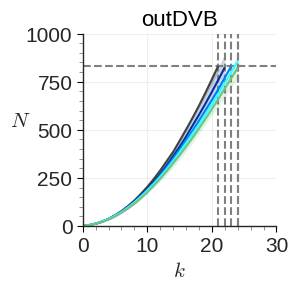

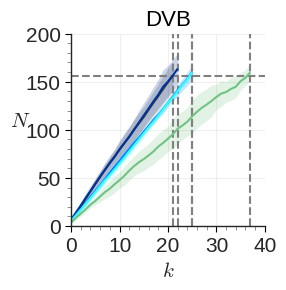

In [144]:
# DFallDiscslimitcounts = df
y_prop = 'cumcount'
x_prop = 'k_dist'

data = df.groupby(['k_dist','region','devstage','discName'])['cumcount'].agg(['mean']).reset_index().rename(columns={'mean':'cumcount'})
data = data.groupby(['k_dist','region','devstage'])[y_prop].agg(['mean','std','count']).reset_index()
colnames = [y_prop+'_'+x if x in(['mean','std']) else x for x in data.columns]
data.columns = colnames

subset =  data.loc[data['devstage'].isin(devstages)]
for roi in ['outDV','DV']:

    fig,ax = plt.subplots(1,1, figsize = (2.5, 2.5)
                      )
    hline = subset[(subset['region']==roi)&(subset['devstage']=='wL3')][y_prop + '_mean'].max()
    ax.axhline(hline, color = 'grey', linestyle='--')  
    for devstage in devstages:
        data = subset[(subset['region']==roi)&(subset['devstage']==devstage)]
        vline = data[x_prop].max()
        ax.axvline(vline, color = 'grey', linestyle='--', linewidth = 1.5)   
         
        # ax.errorbar(x = data[x_prop], y = data[y_prop + '_mean'], yerr = data[y_prop + '_std'],color = colors[devstage])
        
        ax.fill_between(x = data[x_prop], y1 = data[y_prop + '_mean'] - data[y_prop + '_std'], y2 = data[y_prop + '_mean'] + data[y_prop + '_std'], color = colors[devstage], alpha = 0.2, linewidth = 0)
        ax.plot(data[x_prop], data[y_prop + '_mean'],color = colors[devstage])
    

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))

    if roi == 'outDV':
        ax.set_ylim(0,1000)
        ax.set_xlim(0,30)
        ax.set_yticks(np.arange(0,1001,250))
        ax.yaxis.set_major_locator(MultipleLocator(250))
        ax.yaxis.set_minor_locator(MultipleLocator(50))
        title = 'outDVB'

    elif roi == 'DV':
        ax.set_ylim(0,200)
        ax.set_xlim(0,40)
        ax.set_yticks(np.arange(0,201,50))
        ax.set_xticks(np.arange(0,41,10))
        ax.yaxis.set_major_locator(MultipleLocator(50))
        ax.yaxis.set_minor_locator(MultipleLocator(10))
        title = 'DVB'

    ax.tick_params(axis='both', which = 'major', color = 'black',length = 4)
    ax.tick_params(axis='both', which = 'minor', color = 'gray',length = 3)
    ax.grid(which = 'major', axis = 'both', alpha = 0.3)
    #ax.tick_params(axis='both', which='major', labelsize=15)

    xlabel = r'$k$'
    ylabel = r'$N$'

    ax.set_xlabel(xlabel, rotation = 'horizontal')
    ax.set_ylabel(ylabel, rotation = 'horizontal')
    ax.set_title(title)
    #plt.savefig(dataout +'/' + y_prop + 'over' + x_prop + roi + '-HV-line-std-wL3.pdf',dpi = 600,bbox_inches = 'tight')
    plt.savefig(dataout +'/'+ genotype + y_prop + 'over' + x_prop + roi +  '-HV-line-std-all.pdf',dpi = 600,bbox_inches = 'tight')

## compare absolute Changes

In [95]:
compareStepwise = False
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[0:]})


prop = 'area'
# [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide',
#                                                    devstage_combinations=devstage_combinations)

[area_diff, area_diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide-sqrt',
                                                   devstage_combinations=devstage_combinations, 
                                                   fit_param = 'ref_pathlength_scaled_beta_mean'
                                                  )

In [49]:
compareStepwise = False
prop = 'Qrr_geom_inPlane'
[diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'subtract',
                                                    devstage_combinations=devstage_combinations,
                                                   fit_param = 'ref_pathlength_scaled_beta_mean')


In [50]:
print(genotype)

ecadGFPnbG4


In [ ]:
stat_df_abs = area_diff

''' 
prop + _alpha is a point estimate of the mean per disc and k(interpolate), which is a reasonable approximation due to the large cell number
now find the precision of this measure across discs (x!=u)
and use a plug in estimate of the mean
'''

def draw_bs_sample(data):
    return np.random.choice(data, size=len(data), replace = True)
def draw_bs_reps(data, stats_method, size=1, args=() ):
    return np.array([stats_method(draw_bs_sample(data, *args)) for _ in range(size)])
    # stats_method is a placeholder for np.mean here


for roi in rois: 
    for d in range(len(devstages)):
        devstage = devstages[d]
        for k in range(0,stat_df_abs['k_beta'].max()+1):
            # absolute values 
            datapoints = stat_df_abs.loc[(stat_df_abs['k_beta']==k)&(stat_df_abs['devstage_final']==devstage)&(stat_df_abs['roi']==roi)][prop+'_alpha'].values
            bs_reps = draw_bs_reps(datapoints, np.mean, size =10_000)
            conf_int = np.percentile(bs_reps,[2.5,97.5])
            stat_df_abs.loc[(stat_df_abs['k_beta']==k)&(stat_df_abs['devstage_final']==devstage)&(stat_df_abs['roi']==roi),prop + '_plugInMean'] = np.mean(bs_reps)
            stat_df_abs.loc[(stat_df_abs['k_beta']==k)&(stat_df_abs['devstage_final']==devstage),prop + '_conf_int95'] = np.abs(conf_int[0]-conf_int[1])/2
stat_df_abs = stat_df_abs.groupby(['roi','devstage_init','devstage_final','k_beta', prop + '_conf_int95', prop + '_plugInMean'])[['N_beta']].agg(['mean','std','count']).reset_index()
#removing multi-indexing
colnames = [x[0]+'_'+x[1] if x[1] != '' else x[0] for x in stat_df_abs.columns]
stat_df_abs.columns = colnames 

outDV
DV


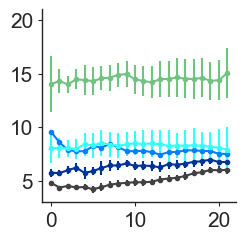

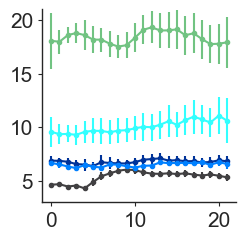

In [ ]:
rois = ['outDV', 'DV']
x_axis = 'k_beta'
stats = '95CI'

devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[0:]})
for roi in rois:
    print(roi)
    fig,ax = plt.subplots(
                        figsize = (2.5,2.5))
    if roi == 'DV':
        xlim = (0,160)
    else:
        xlim = (0,850)

    # 
    if prop == 'area':
        ylim = (3,21)
        ax.set_yticks(np.arange(5,21,5))
        # ax.set_ylabel(r'$A$', fontsize = 20,labelpad=10, rotation = 'horizontal')
    
        
    else:
        ylim=(-0.17,0.17)   
        ax.axhline(0, color ='grey')
        # ax.set_ylabel(r'$Qrr$', fontsize = 20,labelpad=10, rotation = 'horizontal')
        

    ax.set_ylim(ylim)
    for j in range(len(devstage_combinations)):
     
        devstage_init = devstage_combinations.loc[j,'devstage_init']
        devstage_final = devstage_combinations.loc[j,'devstage_final']        
        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
        data = stat_df_abs.query(query_str)
    
        if x_axis == 'N_beta':
            xlabel = r'$N$'
            ylabel = prop 
        else:
            xlabel = x_axis
            xlabel = r'$κ$'
            xlabel = r'$K$'


        if x_axis == 'N_beta':
            data = data.sort_values(x_axis +'_mean', ascending=False)
            data = data.loc[data[x_axis+'_mean']>2]
            ax.errorbar(x = data[x_axis + '_mean'], y = data[prop + '_plugInMean'], xerr= data[x_axis + '_std'], yerr= data[prop + '_conf_int95'],color = colors[devstage_final],
        marker = '.', linestyle = '-')
        else:
            ax.errorbar(x = data[x_axis], y = data[prop + '_plugInMean'], yerr= data[prop + '_conf_int95'],color = colors[devstage_final],
        marker = '.', linestyle = '-')
            data = data.sort_values(x_axis, ascending=False)
        
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(visible=None)
    # ax.grid(visible=True, which='major', axis='y')
    # ax.set_xlabel(xlabel, fontsize = 20,labelpad=4, rotation = 'horizontal')
    # ax.set_title(roi + ' region')
    plt.savefig(dataout + genotype + prop + roi + '_k(n)_y95CI-eversion.pdf',dpi = 600,bbox_inches = 'tight')

In [ ]:
#comapreQrr and elongmax
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde



for roi in ['outDV']:
    for devstage in devstages:    
        print(devstage)
        fig,ax = plt.subplots(
                        figsize = (5, 4))

        if roi == 'outDV':
            styleROI = '-'
        else:
            styleROI = '-'


        toplot = df.loc[(df['region']==roi)&(df['devstage']==devstage)]
        x = toplot['elongation_tensor_norm_max'].values
        y = np.abs(toplot['Qrr_geom_inPlane'].values)
        nbins=200
        k = kde.gaussian_kde([x,y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 

        # Make the plot
        ax.set_ylim(0,0.5)
        ax.set_xlim(-0,0.8)
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
        plt.savefig(dataout + '/density_gaussiankde_qrr_over_elongMax_' + devstage + '.png')
        
        # ax.scatter(toplot['elongation_tensor_norm_max'], toplot['Qrr_geom_inPlane'], color = colors[devstage], alpha = 1)


## calculate lambda tensors

### not used

In [75]:
#function to compare between pairs of stages

compareStepwise = True
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[1:]})



prop = 'area'

[diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide-sqrt',
                                                   devstage_combinations=devstage_combinations, 
                                                   fit_param = 'ref_pathlength_scaled_beta_mean'
                                                  )

# prop = 'exp_signed_Qnorm'

# [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide',
#                                                    devstage_combinations=devstage_combinations,
#                                                    fit_param='ref_pathlength_scaled_beta_mean',
#                                               )

# prop = 'lambda_rearrangement'

# [k_N_alldiscs, k_N_mean] = Ntools.analyze_ring_cell_numbers(df, devstages = devstages)
# [diff, diff_stat] = Ntools.get_k_differences(k_N_alldiscs, devstage_combinations = devstage_combinations, rois = rois, fit_param = 'ref_pathlength_scaled_beta_mean', N_ref_pathlength_dict = k_scaled_dist_dict)
# ylabel = r'$\tilde{\lambda}_{Re}$'


In [ ]:
#plotting

rois = ['outDV', 'DV']

nbcols = len(devstage_combinations)
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                    figsize = (2*nbcols, 2*nbrows)
                    )
main_ax = fig.add_subplot(111, frameon=False)


            
if prop == 'area':
    operation = 'divide-sqrt'
    ylabel = r'${\lambda}$'
    prop = prop + '_diff'

elif prop == 'exp_signed_Qnorm':
    operation = 'divide'
    ylabel = r'$\tilde{\lambda}_{Q}$'
    prop = prop + '_diff'

elif prop == 'lambda_rearrangement':
    ylabel = r'$\tilde{\lambda}_{Re}$'



for i in range(len(rois)):
    roi = rois[i]

    for j in range(len(devstage_combinations)):

        devstage_init = devstage_combinations.loc[j,'devstage_init']
        devstage_final = devstage_combinations.loc[j,'devstage_final']        
        print(devstage_final)
        ax = axs[i,j]
        ax.axhline(1, linestyle = '-', linewidth = '0.4', color ='grey')
        label_init = devstage_init
        label_final = devstage_final
        title = label_init + r'$ \to $' + label_final
        axs[0,j].set_title(title, fontsize = 15, pad = 15)
        axs[i,0].set_yticks(np.arange(0.6,1.6, 0.4))
        axs[1,j].set_xticks([0.0,0.5,1.0])
        axs[i,1].set_yticklabels(['','','',])
        axs[i,2].set_yticklabels(['','','',])
        axs[i,3].set_yticklabels(['','','',])
        axs[0,j].set_xticklabels(['','','',])

        

        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
        data = diff_stat.query(query_str)
        x_col = 'ref_pathlength_scaled_beta_mean'
        # y_col = prop + '_diff'

        ax.plot(data[x_col], data[prop +'_mean'], color = colors[devstage_final])
        ax.fill_between(x = data[x_col], y1 = data[prop +'_mean'] - data[prop +'_std'], y2 = data[prop +'_mean'] + data[prop +'_std'],color = colors[devstage_final], alpha = 0.3)
        ax.plot(data[x_col], data['fit_' + prop ], color = 'black', linestyle = '--')
        ax.tick_params(axis='both', which='major', labelsize=15)
        # axs[1,j].set_xlabel(xlabel, fontsize = 15,labelpad=4, rotation = 'horizontal')

        ax.set_ylim(0.6,1.6)
        ax.set_xlim(0,1.05)

    
    
    main_ax.set_yticks([])
    main_ax.set_xticks([])
    fig.tight_layout()
    
    plt.savefig(dataout + genotype + prop  + '_' + '_std_lamdavsP_stepwise_wFit.pdf',dpi = 600,bbox_inches = 'tight')



In [ ]:
plt.style.use('/Users/fuhrmann/mambaforge/pkgs/matplotlib-base-3.6.3-py39hb2f573b_0/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-custom-whitegrid.mplstyle')

### used

/home/pol_dye/jafu232d//wdeversion_paper/CurvedTM/curvedtm/prop_comparison_methods.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disc_devstage.loc[:,'k_dist'] = df_disc_devstage['k_dist'].values - min(df_disc_devstage['k_dist'])
/home/pol_dye/jafu232d//wdeversion_paper/CurvedTM/curvedtm/prop_comparison_methods.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disc_devstage.loc[:,'k_dist'] = df_disc_devstage['k_dist'].values - min(df_disc_devstage['k_dist'])
/home/pol_dye/jafu232d//wdeversi

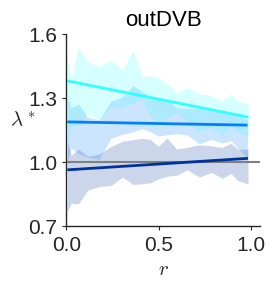

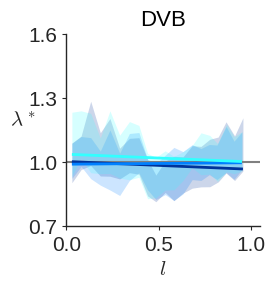

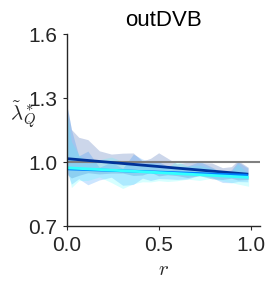

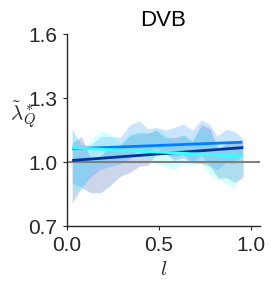

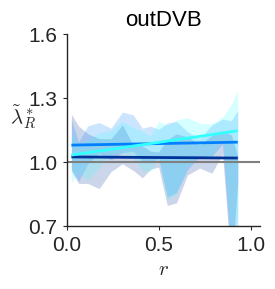

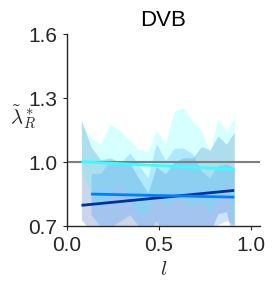

In [125]:
#plotting
rois = ['outDV', 'DV']
nbcols = 1
nbrows = 1
compareStepwise = False
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[1:-1]})

x_col = 'ref_pathlength_scaled_beta_mean'

for prop in ['area','exp_signed_Qnorm']:
    if prop == 'area':
        # operation = 'divide'
        operation = 'divide-sqrt'
        ylabel= r'$\lambda^*$'

    elif prop == 'exp_signed_Qnorm':
        operation = 'divide'
        ylabel= r'$\~\lambda^*_Q$'

    [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = operation,
                                                    devstage_combinations=devstage_combinations,
                                                    fit_param='ref_pathlength_scaled_beta_mean',
                                                )
    for i in range(len(rois)):
        fig,ax = plt.subplots(figsize = (2.5, 2.5)
                        )
        roi = rois[i]
        if roi == 'DV': 
            style = '--' 
            xlabel = r'$l$'
            title = 'DVB'
            
        else:
            style = '-' 
            xlabel = r'$r$'
            title = 'outDVB'
        style = '-' 
        ax.axhline(1, linestyle = '-', color ='grey')
        for j in range(len(devstage_combinations)):

            devstage_init = devstage_combinations.loc[j,'devstage_init']
            devstage_final = devstage_combinations.loc[j,'devstage_final']        
            
            ax.set_yticks(np.arange(0.7,2, 0.3))
            ax.set_xticks([0.0,0.5,1.0])
            query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'

            data = diff_stat.query(query_str)
            ax.fill_between(x = data[x_col], y1 = data[prop +'_diff_mean'] - data[prop +'_diff_std'], y2 = data[prop +'_diff_mean'] + data[prop +'_diff_std'],color = colors[devstage_final], alpha = 0.2, linewidth = 0)
            ax.plot(data[x_col], data['fit_' + prop +'_diff'], color = colors[devstage_final], linestyle = style, linewidth = 2)
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(xlabel, rotation = 'horizontal')
            ax.set_ylabel(ylabel, rotation = 'horizontal')
            ax.set_title(title, loc ='center')
            ax.set_ylim(0.7,1.6)
            ax.set_xlim(0,1.05)       
        plt.savefig(dataout + genotype + prop + roi  + '_' + '_std_lamdavsP_cumulative_wFit_eversion.pdf',dpi = 600,bbox_inches = 'tight')

for prop in ['lambda_rearrangement']:

    [k_N_alldiscs, k_N_mean] = Ntools.analyze_ring_cell_numbers(df, devstages = devstages)
    [k_diff, k_diff_stat] = Ntools.get_k_differences(k_N_alldiscs, devstage_combinations = devstage_combinations, rois = rois, fit_param = 'ref_pathlength_scaled_beta_mean', N_ref_pathlength_dict = k_scaled_dist_dict)
    fit_lambdas_df = Ntools.compile_fit_lambdas_for_sim(k_diff_stat, prop = prop, lambda_name = "lambda_rearrangement_coeffs")
    ylabel = r'$\~\lambda^*_R$'
    for i in range(len(rois)):
        fig,ax = plt.subplots(figsize = (2.5, 2.5)
                        )
        roi = rois[i]
        if roi == 'DV': 
            style = '-' 
            xlabel = r'$l$'
            title = 'DVB'
        else:
            style = '-' 
            xlabel = r'$r$'
            title = 'outDVB'
                    
        ax.axhline(1, linestyle = '-', color ='grey')
        for j in range(len(devstage_combinations)):

            devstage_init = devstage_combinations.loc[j,'devstage_init']
            devstage_final = devstage_combinations.loc[j,'devstage_final']        
            
            ax.set_yticks(np.arange(0.7,2, 0.3))
            ax.set_xticks([0.0,0.5,1.0])
            query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
            data = k_diff_stat.query(query_str)
            ax.fill_between(x = data[x_col], y1 = data[prop + '_mean'] - data[prop +'_std'], y2 = data[prop +'_mean'] + data[prop +'_std'],color = colors[devstage_final], alpha = 0.2, linewidth = 0)
            ax.plot(data[x_col], data['fit_' + prop], color = colors[devstage_final], linestyle = style, linewidth = 2)
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(xlabel, rotation = 'horizontal')
            ax.set_ylabel(ylabel, rotation = 'horizontal')

            ax.set_ylim(0.7,1.6)
            ax.set_xlim(0,1.05)       
            ax.set_title(title, loc ='center')
        plt.savefig(dataout + genotype + prop + roi  + '_' + '_std_lamdavsP_cumulative_wFit_eversion.pdf',dpi = 600,bbox_inches = 'tight')
       




## geometry visualization of lambda

lambda_rearrangement


/home/pol_dye/jafu232d//wdeversion_paper/CurvedTM/curvedtm/prop_comparison_methods.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disc_devstage.loc[:,'k_dist'] = df_disc_devstage['k_dist'].values - min(df_disc_devstage['k_dist'])
/home/pol_dye/jafu232d//wdeversion_paper/CurvedTM/curvedtm/prop_comparison_methods.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disc_devstage.loc[:,'k_dist'] = df_disc_devstage['k_dist'].values - min(df_disc_devstage['k_dist'])
/home/pol_dye/jafu232d//wdeversi

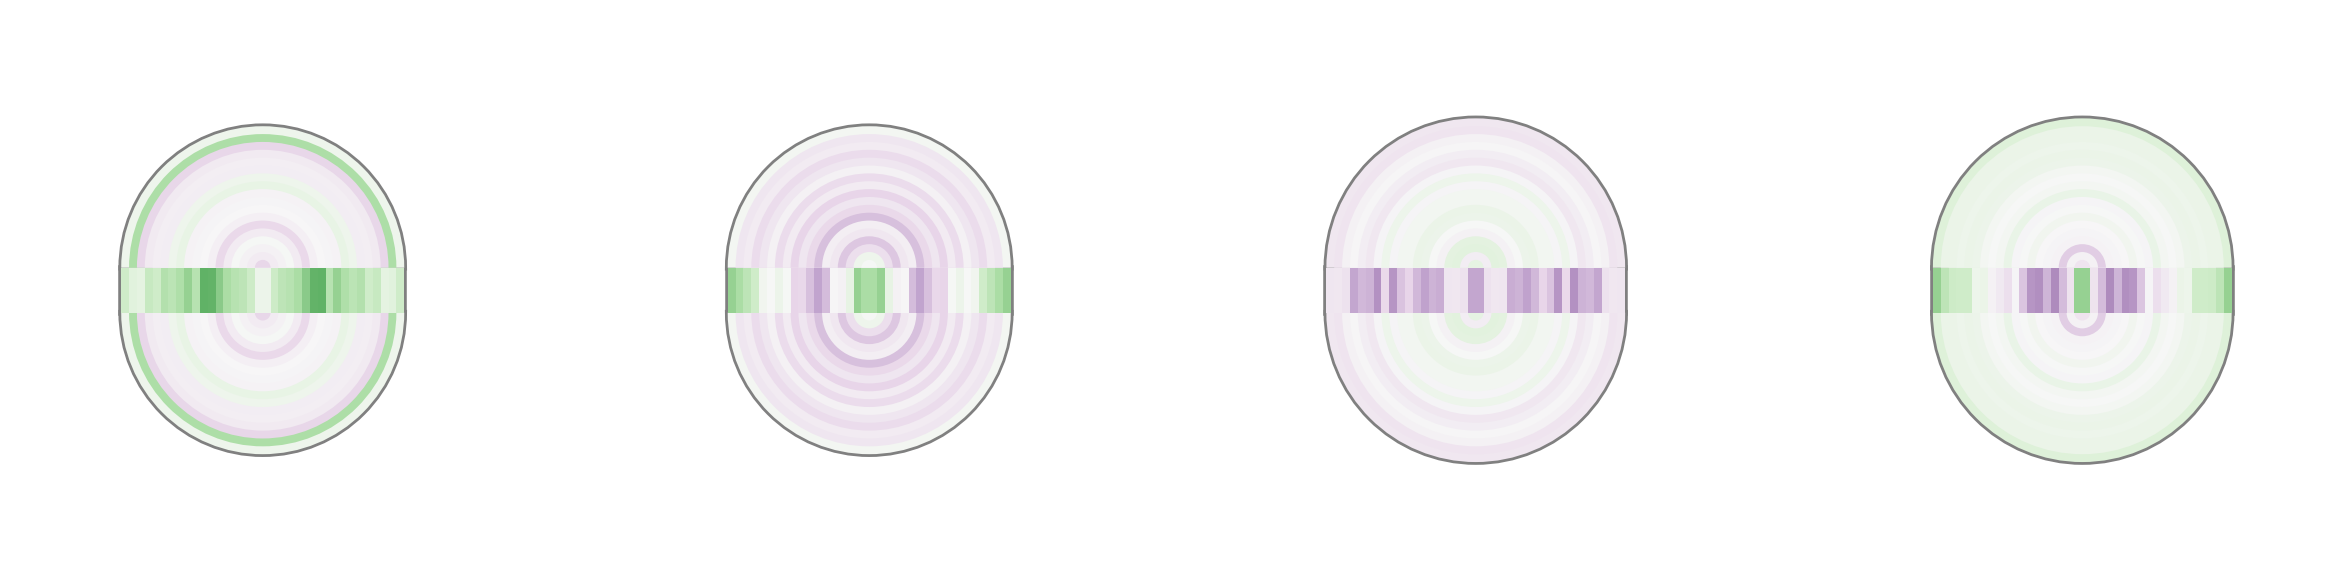

In [126]:
#Visualize Geometry
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm

############################ params
cmap = cm.bwr

climMin = 0.5
climMax = 1.5
compareStepwise = True
fit = False

if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
    changes = 'stepwise'
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[:]})
    changes = 'cumulative'

for prop in ['lambda_rearrangement']:
    print(prop)

    if prop == 'area':
        operation = 'divide-sqrt'
        cmap = cm.PuOr_r



    elif prop == 'exp_signed_Qnorm':
        operation = 'divide'
        cmap = cm.PRGn_r


    elif prop == 'Qrr_geom_inPlane':
        operation = 'divide'
        cmap = cm.PRGn_r

    if prop != 'lambda_rearrangement':

        [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = operation,
                                                        devstage_combinations=devstage_combinations,
                                                        fit_param='ref_pathlength_scaled_beta_mean',
                                                    )
        prop2 = prop +'_diff_mean'


    if prop == 'lambda_rearrangement':

        [k_N_alldiscs, k_N_mean] = Ntools.analyze_ring_cell_numbers(df, devstages = devstages)
        [diff, diff_stat] = Ntools.get_k_differences(k_N_alldiscs, devstage_combinations = devstage_combinations, rois = rois, fit_param = 'ref_pathlength_scaled_beta_mean', N_ref_pathlength_dict = k_scaled_dist_dict)
        ylabel = r'$\tilde{\lambda}_{Re}$'

        prop2 = prop +'_mean'
        cmap = cm.PRGn_r

        
    if prop == 'aniso':
        [k_N_alldiscs, k_N_mean] = Ntools.analyze_ring_cell_numbers(df, devstages = devstages)
        [diff_r, diff_stat_r] = Ntools.get_k_differences(k_N_alldiscs, devstage_combinations = devstage_combinations, rois = rois, fit_param = 'ref_pathlength_scaled_beta_mean', N_ref_pathlength_dict = k_scaled_dist_dict)

        diff_stat_r = diff_stat_r[[	'k_beta','lambda_rearrangement_mean','roi','devstage_init','devstage_final']]
        [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = 'exp_signed_Qnorm',operation = 'divide',
                                                        devstage_combinations=devstage_combinations,
                                                        fit_param='ref_pathlength_scaled_beta_mean',
                                                    )
        diff_stat = diff_stat[['k_beta','exp_signed_Qnorm_diff_mean','roi','devstage_init','devstage_final']]

        diff_stat = diff_stat.merge(diff_stat_r)
        diff_stat['aniso'] = diff_stat['exp_signed_Qnorm_diff_mean']+diff_stat['lambda_rearrangement_mean']-1
        prop2 = 'aniso'

        cmap = cm.PRGn_r



    fitline = ''
    if fit:
        prop2 = 'fit_' + prop +'_diff'
        fitline = '_fit'

    fig, ax = plt.subplots(1,len(devstage_combinations),figsize=(30, 10))
    for j in range(len(devstage_combinations)):
        
        devstage_init = devstage_combinations.loc[j,'devstage_init']
        devstage_final = devstage_combinations.loc[j,'devstage_final']   
        

        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '")'
        data = diff_stat.query(query_str)
        #data[['k_beta','fit_exp_signed_Qnorm_diff','roi']]
        # data[['k_beta','exp_signed_Qnorm_diff_mean','roi']]
        data = data.sort_values(['k_beta'],ascending=False)

        values = data.loc[data['roi']=='outDV'][prop2].values
        valuesDV = data.loc[data['roi']=='DV'][prop2].values

        from matplotlib.collections import PatchCollection
        #ax.set_aspect('equal')

        patches1 = []
        patches2 = []
        patches3 = []
        patches4 = []
        angle = 0
        scaling = 0.017
        scaling = 0.014
        theta1, theta2 = angle, angle + 180
        resolution = 100

        climDVMin = climMin
        climDVMax =  climMax

        for i in range(len(values),0,-1):
            radius= i*scaling
            w1 = Wedge((0, 0.04), radius, theta1, theta2, lw=2)
            for wedge in [w1]:
                patches1.append(wedge)
        p1 = PatchCollection(patches1, alpha=1, cmap=cmap)
        colorsDorsal = values
        p1.set_array(colorsDorsal)
        p1.set_clim([climMin, climMax])


        for i in range(len(values),0,-1):
            radius= i*scaling
            w2 = Wedge((0, -0.04), radius, theta2, theta1, lw=2)
            for wedge in [w2]:
                patches2.append(wedge)
        p2 = PatchCollection(patches2, alpha=1, cmap=cmap)
        colorsVentral = values
        p2.set_array(colorsVentral)
        p2.set_clim([climMin, climMax])
        
        for i in range(len(values),0,-1):
            positionX = 0
            polygon = Rectangle((positionX, -0.04), width=scaling*i, height=0.08, angle=0.0) 
            patches3.append(polygon)
            p3 = PatchCollection(patches3, cmap=cmap, ec = 'grey', linewidth = 0)
            colorsDV = valuesDV
            p3.set_array(colorsDV)
            p3.set_clim([climDVMin, climDVMax])
            
        for i in range(len(values),0,-1):
            positionX = -(i*scaling)
            polygon = Rectangle((positionX, -0.04), width=scaling, height=0.08, angle=0.0) 
            patches4.append(polygon)
            p4 = PatchCollection(patches4, cmap=cmap, ec = 'grey', linewidth = 0)
            colorsDV = valuesDV
            p4.set_array(colorsDV)
            p4.set_clim([climDVMin, climDVMax])
        col = j 
        ax[col].set_aspect('equal')
        p5 = Rectangle((-len(values)*scaling,-0.04), width=len(values)*scaling*2, height=0.08, angle=0.0, linewidth=4, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p5)
        p6 = Wedge((0,+0.04),len(values)*scaling, theta1, theta2,  linewidth=4, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p6)
        p7 = Wedge((0,-0.04),len(values)*scaling, theta2, theta1,  linewidth=4, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p7)

        
        ax[col].add_collection(p1)
        ax[col].add_collection(p2)
        ax[col].add_collection(p3)
        ax[col].add_collection(p4)

        ax[col].set_xlim(-0.45,0.45)
        ax[col].set_ylim(-0.5,0.5)
        ax[col].set_axis_off()


    plt.savefig(dataout + genotype + prop  + '_' + prop2 + '_' + 'changes_'+ changes + '_geometry_all'+ fitline + '.pdf',dpi = 300,bbox_inches = 'tight')


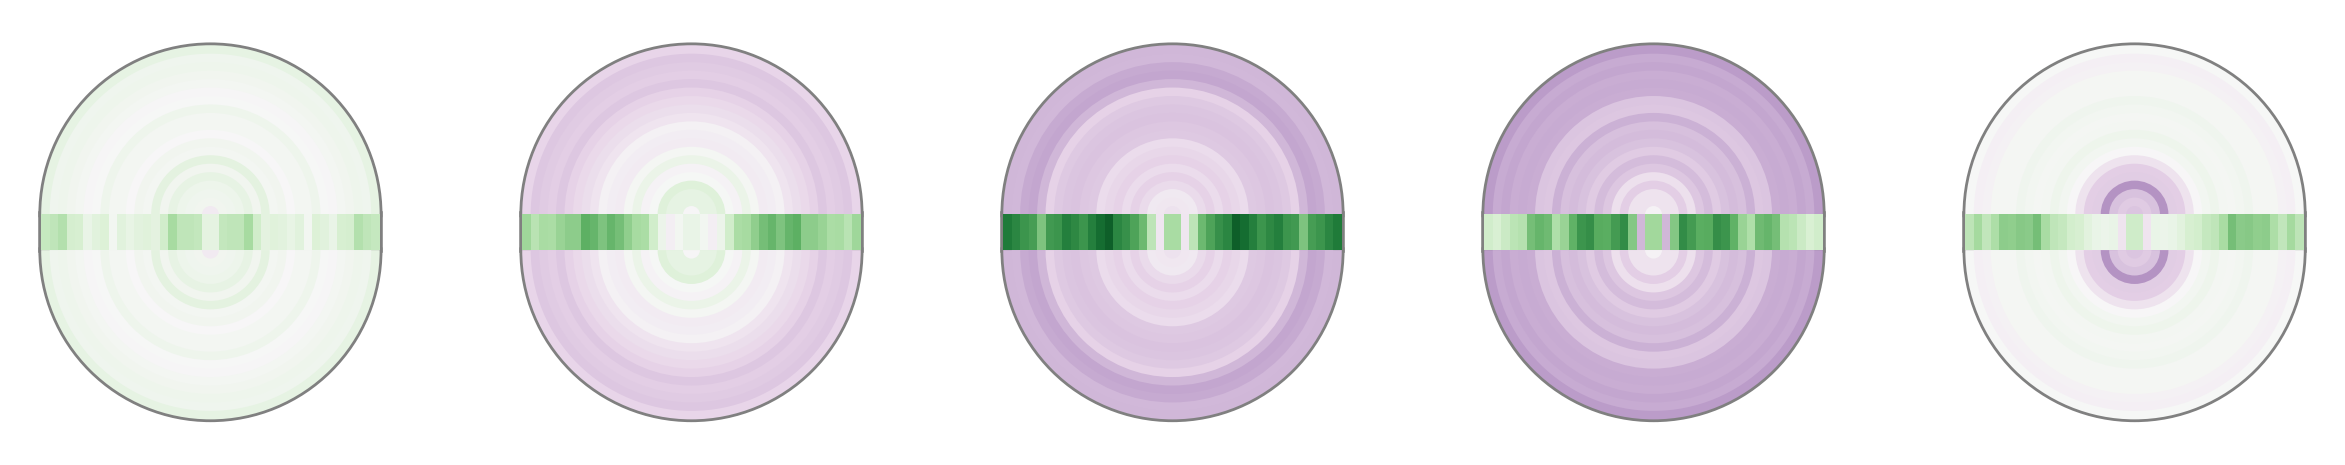

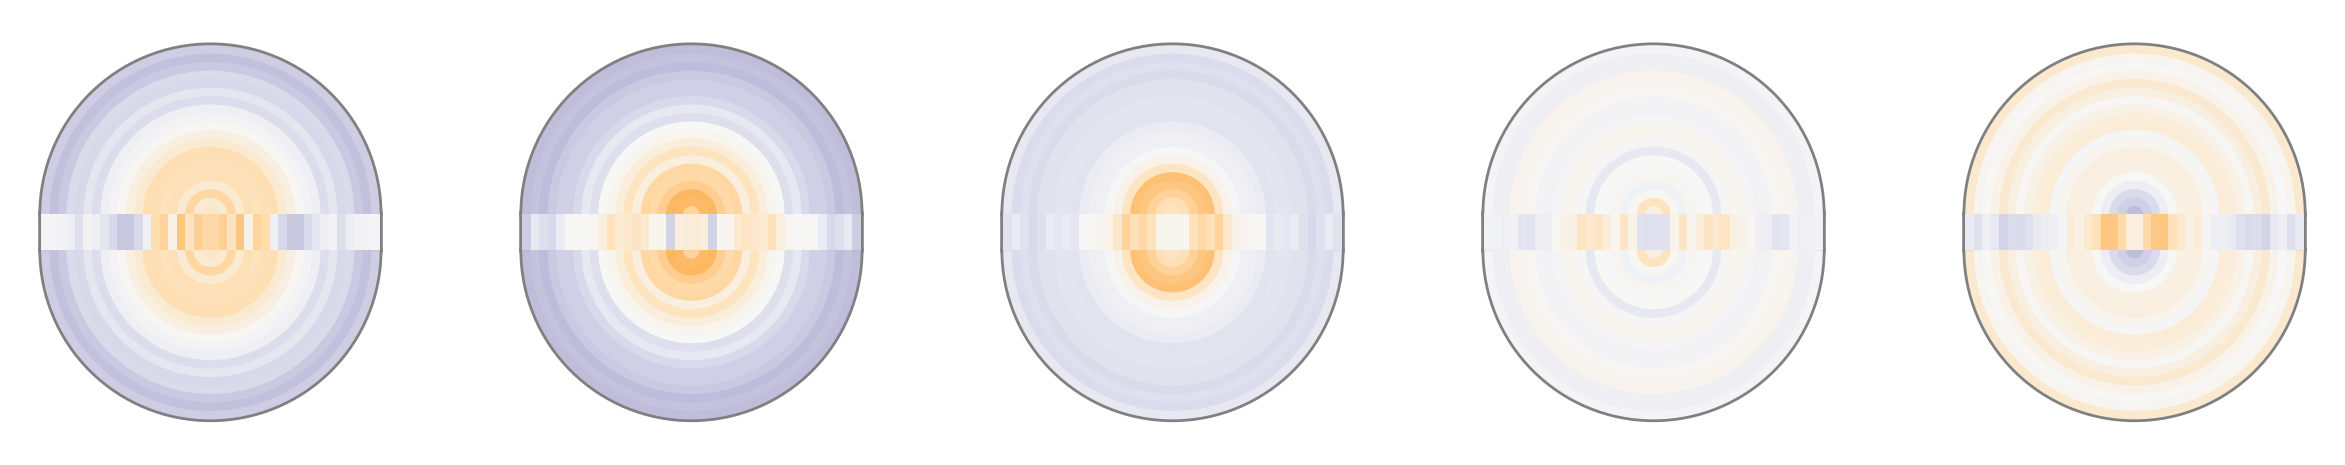

In [127]:
#Visualize Geometry
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm

############################ params
# cmap = cm.bwr

compareStepwise = False
fit = False

if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
    changes = 'stepwise'
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[0:]})
    changes = 'cumulative'


for prop in ['Qrr_geom_inPlane','area']:

    if prop == 'area':
        operation = 'divide-sqrt'
        cmap = cm.PuOr



    elif prop == 'exp_signed_Qnorm':
        operation = 'divide'
        cmap = cm.PRGn


    elif prop == 'Qrr_geom_inPlane':
        operation = 'divide'
        cmap = cm.PRGn

    [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = operation,
                                                    devstage_combinations=devstage_combinations,
                                                    fit_param='ref_pathlength_scaled_beta_mean',
                                                )
    prop2 = prop +'_alpha_mean'

    fitline = ''
    if fit:
        prop2 = 'fit_' + prop +'_diff'
        fitline = '_fit'

    fig, ax = plt.subplots(1,len(devstage_combinations),figsize=(30, 10))
    for j in range(len(devstage_combinations)):
        
        devstage_init = devstage_combinations.loc[j,'devstage_init']
        devstage_final = devstage_combinations.loc[j,'devstage_final']   
        

        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '")'
        data = diff_stat.query(query_str)
        #data[['k_beta','fit_exp_signed_Qnorm_diff','roi']]
        # data[['k_beta','exp_signed_Qnorm_diff_mean','roi']]
        data = data.sort_values(['k_beta'],ascending=False)

        values = data.loc[data['roi']=='outDV'][prop2].values
        valuesDV = data.loc[data['roi']=='DV'][prop2].values



        from matplotlib.collections import PatchCollection
        #ax.set_aspect('equal')

        patches1 = []
        patches2 = []
        patches3 = []
        patches4 = []
        angle = 0
        scaling = 0.019
        # scaling = 0.01
        theta1, theta2 = angle, angle + 180
        resolution = 100

        # climDVMin = climMin
        # climDVMax =  climMax

        if prop == 'area':
            climMin = values.mean() *0.5
            climMax = values.mean() *1.5

            climDVMin = valuesDV.mean() *0.5
            climDVMax = valuesDV.mean() *1.5

        elif prop == 'exp_signed_Qnorm':
            climMin = 0.9
            climMax = 1.2

            climDVMin = climMin
            climDVMax =  climMax

        elif prop == 'Qrr_geom_inPlane':    
            climMin = -0.15
            climMax = 0.15

            climDVMin = climMin
            climDVMax =  climMax


        for i in range(len(values),0,-1):
            radius= i*scaling
            w1 = Wedge((0, 0.04), radius, theta1, theta2, lw=2)
            for wedge in [w1]:
                patches1.append(wedge)
        p1 = PatchCollection(patches1, alpha=1, cmap=cmap)
        colorsDorsal = values
        p1.set_array(colorsDorsal)
        p1.set_clim([climMin, climMax])


        for i in range(len(values),0,-1):
            radius= i*scaling
            w2 = Wedge((0, -0.04), radius, theta2, theta1, lw=2)
            for wedge in [w2]:
                patches2.append(wedge)
        p2 = PatchCollection(patches2, alpha=1, cmap=cmap)
        colorsVentral = values
        p2.set_array(colorsVentral)
        p2.set_clim([climMin, climMax])
        
        for i in range(len(values),0,-1):
            positionX = 0
            polygon = Rectangle((positionX, -0.04), width=scaling*i, height=0.08, angle=0.0) 
            patches3.append(polygon)
            p3 = PatchCollection(patches3, cmap=cmap, ec = 'grey', linewidth = 0)
            colorsDV = valuesDV
            p3.set_array(colorsDV)
            p3.set_clim([climDVMin, climDVMax])
            
        for i in range(len(values),0,-1):
            positionX = -(i*scaling)
            polygon = Rectangle((positionX, -0.04), width=scaling, height=0.08, angle=0.0) 
            patches4.append(polygon)
            p4 = PatchCollection(patches4, cmap=cmap, ec = 'grey', linewidth = 0)
            colorsDV = valuesDV
            p4.set_array(colorsDV)
            p4.set_clim([climDVMin, climDVMax])
        col = j 
        ax[col].set_aspect('equal')
        p5 = Rectangle((-len(values)*scaling,-0.04), width=len(values)*scaling*2, height=0.08, angle=0.0, linewidth=4, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p5)

        p6 = Wedge((0,+0.04),len(values)*scaling, theta1, theta2,  linewidth=4, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p6)
        p7 = Wedge((0,-0.04),len(values)*scaling, theta2, theta1,  linewidth=4, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p7)

        
        ax[col].add_collection(p1)
        ax[col].add_collection(p2)
        ax[col].add_collection(p3)
        ax[col].add_collection(p4)

        ax[col].set_xlim(-0.45,0.45)
        ax[col].set_ylim(-0.5,0.5)
        ax[col].set_axis_off()

    plt.savefig(dataout + genotype + prop  + '_' + prop2 + '_' + '_geometry_all'+ fitline + '.pdf',dpi = 300,bbox_inches = 'tight')


## MYOVI

In [ ]:
### Set path to directory containing the Tissue Miner movies
import os
# datapath_base   = codeRepo + '/CellshapeData/'
datapath_base = '/Volumes/pol_dye_drosophilawing/P-WDeversion/curvedTM/data/'
datapath_tissue_miner = os.getcwd()
genotype = 'ecadGFPnbG4myoVI'
dataout =  '/Volumes/pol_dye_drosophilawing/P-WDeversion/curvedTM/plotting/PaperPlots/' 
datapath = os.path.join(datapath_base, genotype)
frameIdx = 0

exist = os.path.exists(dataout)
if not exist:
   os.makedirs(dataout)

In [54]:
plt.style.use('/Users/fuhrmann/mambaforge/pkgs/matplotlib-base-3.6.3-py39hb2f573b_0/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-custom-whitegrid.mplstyle')

In [55]:
with open(datapath_base + 'DFallDiscs' + 'limitcounts.pkl','rb') as f:
   df = pickle.load(f)
df = df[df['genotype'] == genotype]
df["devstage"] = [devstage_map[x] for x in df["devstage"].values]
df = df[columns]


In [56]:
groupby_cols = ['devstage', 'region', 'discName', 'k_dist']
#here we pool cells within a ring and calculate the mean
df_pool_k = df.groupby(groupby_cols).agg('mean').reset_index() 
#we offset k_dist values if the rings do not start with k_dits = 0
k_dist_offset = df.groupby(['discName']).k_dist.agg('min')#.reset_index().set_index('discName') #some discs can have k starting from non-zero value, so we offset them by the starting k
df_pool_k['k_dist'] = df_pool_k['k_dist'] - k_dist_offset[df_pool_k['discName'].values].values #offsetting k values


#scale pathlength
pathlength_max = df_pool_k.groupby(['discName']).k_dist_pathlength.agg('max')
df_pool_k['pathlength_scaled'] = df_pool_k['k_dist_pathlength']/pathlength_max[df_pool_k['discName'].values].values
#compute Qnorm and exponential of Qnorm - to be used later
#function to compute area weighted average
wm = lambda x: np.average(x, weights=df.loc[x.index, "area"])

df_pool_areaWeighted_k = df.groupby(groupby_cols).agg(Qrr_geom_inPlane = pd.NamedAgg(column = 'Qrr_geom_inPlane', aggfunc = wm),
                                                      Qrphi = pd.NamedAgg(column = 'Qrphi', aggfunc = wm),
                                                      Qphiphi = pd.NamedAgg(column = 'Qphiphi', aggfunc = wm),
                                                     ).reset_index() 
df_pool_k[["Qrr_geom_inPlane", "Qrphi", "Qphiphi"]] = df_pool_areaWeighted_k[["Qrr_geom_inPlane", "Qrphi", "Qphiphi"]]

df_pool_k['Qnorm'] = np.sqrt(df_pool_k['Qrr_geom_inPlane']**2 + df_pool_k['Qrphi']**2)
df_pool_k['exp_signed_Qnorm'] = np.exp(np.sign(df_pool_k['Qrr_geom_inPlane'])*df_pool_k['Qnorm'])

/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/846196081.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pool_k = df.groupby(groupby_cols).agg('mean').reset_index()


In [57]:
groupby_cols = ['devstage', 'region', 'k_dist']
#here we pool discs within a devstage and calculate the mean and std
df_pool_devstage = df_pool_k.groupby(groupby_cols).agg(['mean', 'std']).reset_index()
colnames = [x[0]+'_'+x[1] if x[0] not in groupby_cols else x[0] for x in df_pool_devstage.columns]
df_pool_devstage.columns = colnames #removing multi-indexing

#compute Qnorm
df_pool_devstage['Qnorm_mean'] =  np.sqrt( df_pool_devstage['Qrr_geom_inPlane_mean']**2 + df_pool_devstage['Qrphi_mean']**2)#Norm of mean
df_pool_devstage['Qnorm_std'] = (df_pool_devstage['Qrr_geom_inPlane_mean']*df_pool_devstage['Qrr_geom_inPlane_std'] + df_pool_devstage['Qrphi_mean']*df_pool_devstage['Qrphi_std'])/df_pool_devstage['Qnorm_mean']

df_pool_devstage['exp_signed_Qnorm_mean'] = np.exp(np.sign(df_pool_devstage['Qrr_geom_inPlane_mean'])*df_pool_devstage['Qnorm_mean'])
df_pool_devstage['exp_signed_Qnorm_std'] = df_pool_devstage['exp_signed_Qnorm_mean']*df_pool_devstage['Qnorm_std']


/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/1143488363.py:3: FutureWarning: ['discName'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_pool_devstage = df_pool_k.groupby(groupby_cols).agg(['mean', 'std']).reset_index()


## Pathlength analysis

As we will use $N$(cumcount) to track regions between discs, we want to fit a polynomial to get the mapping between N and the reference scaled pathlength($p$).
The scaled pathlength $p$ is a dimensionless coordinate for the distance from the $k = 0$ location.
In the previous cells we already computed $p$ as $\text{k_dist_pathlength}/\max(\text{k_dist_pathlength})$ for each discName.

In [58]:
k_scaled_dist_dict = dict() #a dictionary for storing the polynomial object for fitting between fractional pathlength and N
devstage = "wL3"

from scipy.optimize import curve_fit
#for DV
roi = "DV"
query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
df_roi_stage = df_pool_devstage.query(query_str)
#doing a linear fit going through 0,0
def func(x, a):
    return a*x
popt, pcov = curve_fit(func, df_roi_stage['cumcount_mean'], df_roi_stage['pathlength_scaled_mean'])
p_DV_coeff = popt[0]
def p_DV(x):
    return(p_DV_coeff*x)
k_scaled_dist_dict[roi] = p_DV #coeffs[1] is supposed to be zero (very small value compared to 1 which is the max value of scaled dist)

#for outDV
roi = "outDV"
query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
df_roi_stage = df_pool_devstage.query(query_str)
#doing a linear fit going through 0,0
def func(x, a, b, c, d, e):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x
popt, pcov = curve_fit(func, df_roi_stage['cumcount_mean'], df_roi_stage['pathlength_scaled_mean'])
p_outDV_coeff = popt
def p_outDV(x):
    return p_outDV_coeff[0]*x**5 + p_outDV_coeff[1]*x**4 + p_outDV_coeff[2]*x**3 + p_outDV_coeff[3]*x**2 + p_outDV_coeff[4]*x
k_scaled_dist_dict[roi] = p_outDV #coeffs[1] is supposed to be zero (very small value compared to 1 which is the max value of scaled dist)

df_pool_k["ref_pathlength_scaled"] = df_pool_k.apply(lambda row: k_scaled_dist_dict[row['region']](row["cumcount"]),axis = 1)
df_pool_devstage["ref_pathlength_scaled"] = df_pool_devstage.apply(lambda row: k_scaled_dist_dict[row['region']](row['cumcount_mean']),axis = 1)

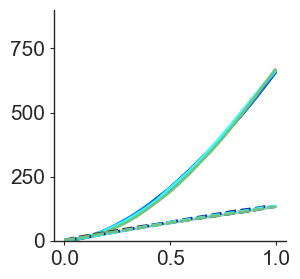

In [59]:
nbcols = 1
nbrows = 1

fig,ax = plt.subplots(nbrows, nbcols,
                       figsize = (3, 3)
                      )
for i in [0,1]:
    roi = rois[i]   
    if roi == 'DV':
        linestyle = '--'
    elif roi == 'outDV':
        linestyle = '-'
    for j in range(len(devstages)):   
        devstage = devstages[j]
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
    
        ax.set_ylim(0,900)
        # ax.set_xlim(0,220)
        ax.set_yticks(np.arange(0,910,250))


        stat_df = df_pool_devstage.query(query_str)
        x_col = 'cumcount'
        y_col = 'pathlength_scaled'
        
        x_col_mean = x_col + '_mean'
        y_col_mean = y_col + '_mean'
        x_col_std = x_col + '_std'
        y_col_std = y_col + '_std'
        yerr = stat_df[y_col_std]

        ax.fill_between(stat_df[y_col_mean], stat_df[x_col_mean] - yerr, stat_df[x_col_mean] + yerr, color = color_dict[devstage], alpha = 0.2)            

        ax.plot(stat_df[y_col_mean], stat_df[x_col_mean], color = color_dict[devstage], lw = 2, label = devstage, linestyle = linestyle)
        
    query_str = '(devstage == "' + 'wL3' + '") & (region == "' + roi + '")'
    df_roi_stage = df_pool_devstage.query(query_str)
    # ax.plot(df_roi_stage['cumcount_mean'], df_roi_stage['ref_pathlength_scaled'], linestyle = '--', color = "red", linewidth = 2, label = 'fit')

plt.savefig(dataout +'/' + genotype + '_rho_vs_N-noIncreaselimits.pdf',dpi = 600,bbox_inches='tight')

/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/2862858853.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data = data.groupby(['k_dist','region','devstage'])[x_prop,y_prop].agg(['mean','std']).reset_index()


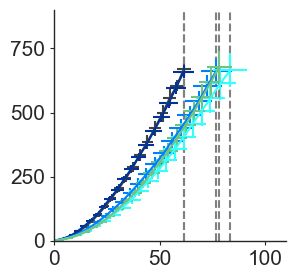

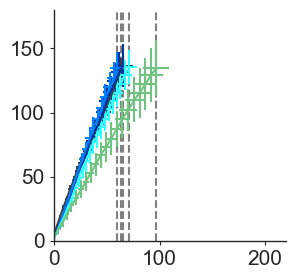

In [60]:
DFallDiscslimitcounts = df
data = DFallDiscslimitcounts[DFallDiscslimitcounts['k_dist']>=0].sort_values('k_dist')
y_prop = 'cumcount'
x_prop = 'k_dist_pathlength'
data = DFallDiscslimitcounts[DFallDiscslimitcounts['k_dist']>=0].sort_values('k_dist')
data = data.groupby(['k_dist','region','devstage'])[x_prop,y_prop].agg(['mean','std']).reset_index()
colnames = [x[0]+'_'+x[1] if x[1] != '' else x[0] for x in data.columns]
data.columns = colnames

subset =  data.loc[data['devstage'].isin(devstages)]
for roi in ['outDV','DV']:
    
    fig,ax = plt.subplots(1,1, figsize = (3, 3)
                      )
    for devstage in devstages:
        data = subset[(subset['region']==roi)&(subset['devstage']==devstage)]
        vline = data[x_prop + '_mean'].max()
        ax.axvline(vline, color = 'grey', linestyle='--')   
        ax.errorbar(x = data[x_prop + '_mean'], y = data[y_prop + '_mean'], xerr = data[x_prop + '_std'], yerr = data[y_prop + '_std'],color = colors[devstage])
        # ax.plot(data[x_prop + '_mean'], data[y_prop + '_mean'], color = colors[devstage])

    if roi == 'outDV':
        ax.set_ylim(0,900)
        ax.set_xlim(0,110)
        ax.set_yticks(np.arange(0,910,250))
    elif roi == 'DV':
        ax.set_ylim(0,180)
        ax.set_xlim(0,220)
        # ax.set_xticks(np.arange(0,251,50))
    plt.savefig(dataout +'/' +genotype + '_' + y_prop + 'over' + x_prop + roi + '-V-line-std.pdf',dpi = 600,bbox_inches = 'tight')

In [61]:
compareStepwise = False
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[0:]})


prop = 'area'
# [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide',
#                                                    devstage_combinations=devstage_combinations)

[area_diff, area_diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide-sqrt',
                                                   devstage_combinations=devstage_combinations, 
                                                   fit_param = 'ref_pathlength_scaled_beta_mean'
                                                  )

prop = 'Qrr_geom_inPlane'
[diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'subtract',
                                                    devstage_combinations=devstage_combinations,
                                                   fit_param = 'ref_pathlength_scaled_beta_mean')

### compare absolute Values

In [ ]:
stat_df_abs = area_diff

''' 
prop + _alpha is a point estimate of the mean per disc and k(interpolate), which is a reasonable approximation due to the large cell number
now find the precision of this measure across discs (x!=u)
and use a plug in estimate of the mean
'''

def draw_bs_sample(data):
    return np.random.choice(data, size=len(data), replace = True)
def draw_bs_reps(data, stats_method, size=1, args=() ):
    return np.array([stats_method(draw_bs_sample(data, *args)) for _ in range(size)])
    # stats_method is a placeholder for np.mean here


for roi in rois: 
    for d in range(len(devstages)):
        devstage = devstages[d]
        for k in range(0,stat_df_abs['k_beta'].max()+1):
            # absolute values 
            datapoints = stat_df_abs.loc[(stat_df_abs['k_beta']==k)&(stat_df_abs['devstage_final']==devstage)&(stat_df_abs['roi']==roi)][prop+'_alpha'].values
            bs_reps = draw_bs_reps(datapoints, np.mean, size =10_000)
            conf_int = np.percentile(bs_reps,[2.5,97.5])
            stat_df_abs.loc[(stat_df_abs['k_beta']==k)&(stat_df_abs['devstage_final']==devstage)&(stat_df_abs['roi']==roi),prop + '_plugInMean'] = np.mean(bs_reps)
            stat_df_abs.loc[(stat_df_abs['k_beta']==k)&(stat_df_abs['devstage_final']==devstage),prop + '_conf_int95'] = np.abs(conf_int[0]-conf_int[1])/2
stat_df_abs = stat_df_abs.groupby(['roi','devstage_init','devstage_final','k_beta', prop + '_conf_int95', prop + '_plugInMean'])[['N_beta']].agg(['mean','std','count']).reset_index()
#removing multi-indexing
colnames = [x[0]+'_'+x[1] if x[1] != '' else x[0] for x in stat_df_abs.columns]
stat_df_abs.columns = colnames 

outDV
DV


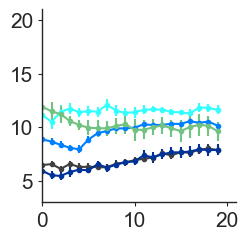

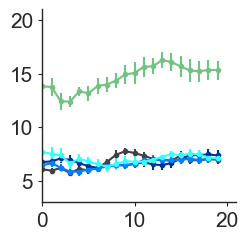

In [ ]:
rois = ['outDV', 'DV']
x_axis = 'k_beta'
stats = '95CI'

devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[0:]})
for roi in rois:
    print(roi)
    fig,ax = plt.subplots(
                        figsize = (2.5,2.5))
    if roi == 'DV':
        xlim = (0,160)
    else:
        xlim = (0,850)

    # 
    if prop == 'area':
        ylim = (3,21)
        ax.set_yticks(np.arange(5,21,5))
        # ax.set_ylabel(r'$A$', fontsize = 20,labelpad=10, rotation = 'horizontal')
    
        
    else:
        ylim=(-0.17,0.17)   
        ax.axhline(0, color ='grey')
        # ax.set_ylabel(r'$Qrr$', fontsize = 20,labelpad=10, rotation = 'horizontal')
        

    ax.set_ylim(ylim)
    for j in range(len(devstage_combinations)):
     
        devstage_init = devstage_combinations.loc[j,'devstage_init']
        devstage_final = devstage_combinations.loc[j,'devstage_final']        
        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
        data = stat_df_abs.query(query_str)
    
        if x_axis == 'N_beta':
            xlabel = r'$N$'
            ylabel = prop 
        else:
            xlabel = x_axis
            xlabel = r'$κ$'
            xlabel = r'$K$'


        if x_axis == 'N_beta':
            data = data.sort_values(x_axis +'_mean', ascending=False)
            data = data.loc[data[x_axis+'_mean']>2]
            ax.errorbar(x = data[x_axis + '_mean'], y = data[prop + '_plugInMean'], xerr= data[x_axis + '_std'], yerr= data[prop + '_conf_int95'],color = colors[devstage_final],
        marker = '.', linestyle = '-')
        else:
            ax.errorbar(x = data[x_axis], y = data[prop + '_plugInMean'], yerr= data[prop + '_conf_int95'],color = colors[devstage_final],
        marker = '.', linestyle = '-')
            data = data.sort_values(x_axis, ascending=False)
    ax.set_xlim(0,21)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(visible=False)
    # ax.grid(visible=False, which='major', axis='y')
    # ax.set_xlabel(xlabel, fontsize = 20,labelpad=4, rotation = 'horizontal')
    # ax.set_title(roi + ' region')
    plt.savefig(dataout + genotype + prop + roi + '_k(n)_y95CI-eversion.pdf',dpi = 600,bbox_inches = 'tight')

### compare changes

In [62]:
compareStepwise = True
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'upcrawling', 'devstage_final':devstages[1:]})

if prop == 'Qrr_areaNormBin':
    [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'subtract',
                                                    devstage_combinations=devstage_combinations)

if prop == 'area':
    # [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide-sqrt',
    #                                                 devstage_combinations=devstage_combinations)
    
    [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide-sqrt',
                                                   devstage_combinations=devstage_combinations, 
                                                   fit_param = 'ref_pathlength_scaled_beta_mean'
                                                  )

stat_df_changes = diff
for roi in rois: 
    for d in range(1,len(devstages)):
        devstage = devstages[d]
        for k in range(0,stat_df_changes['k_beta'].max()+1):
            ### absolute values 
            datapoints = stat_df_changes.loc[(stat_df_changes['k_beta']==k)&(stat_df_changes['devstage_final']==devstage)&(stat_df_changes['roi']==roi)][prop+'_diff'].values
            bs_reps = draw_bs_reps(datapoints, np.mean, size =10_000)
            conf_int = np.percentile(bs_reps,[2.5,97.5])
            stat_df_changes.loc[(stat_df_changes['k_beta']==k)&(stat_df_changes['devstage_final']==devstage)&(stat_df_changes['roi']==roi),prop+'_diff' + '_plugInMean'] = np.mean(bs_reps)
            stat_df_changes.loc[(stat_df_changes['k_beta']==k)&(stat_df_changes['devstage_final']==devstage),prop+'_diff' + '_conf_int95'] = np.abs(conf_int[0]-conf_int[1])/2


stat_df_changes = stat_df_changes.groupby(['roi','devstage_init','devstage_final','k_beta', prop+'_diff' + '_conf_int95', prop+'_diff' + '_plugInMean'])[['N_beta']].agg(['mean','std','count']).reset_index()
#removing multi-indexing
colnames = [x[0]+'_'+x[1] if x[1] != '' else x[0] for x in stat_df_changes.columns]
stat_df_changes.columns = colnames 


In [63]:
#function to compare between pairs of stages

compareStepwise = True
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[1:]})



# prop = 'area'

# [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide-sqrt',
#                                                    devstage_combinations=devstage_combinations, 
#                                                    fit_param = 'ref_pathlength_scaled_beta_mean'
#                                                   )

prop = 'exp_signed_Qnorm'

[diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide',
                                                   devstage_combinations=devstage_combinations,
                                                   fit_param='ref_pathlength_scaled_beta_mean',
                                              )



0hAPF
2hAPF
4hAPF
6hAPF


/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/867758902.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,1].set_yticklabels(['','','',])
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/867758902.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,2].set_yticklabels(['','','',])
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/867758902.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,3].set_yticklabels(['','','',])
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/867758902.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,j].set_xticklabels(['','','',])
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/867758902.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,1].set_yticklabels(['','','',])
/var/folders/kz

0hAPF
2hAPF
4hAPF
6hAPF


/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/867758902.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,1].set_yticklabels(['','','',])
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/867758902.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,2].set_yticklabels(['','','',])
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/867758902.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,3].set_yticklabels(['','','',])
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/867758902.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,j].set_xticklabels(['','','',])
/var/folders/kz/v3hfj4tj1n77b64mg54ffh1w0000gp/T/ipykernel_28444/867758902.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,1].set_yticklabels(['','','',])
/var/folders/kz

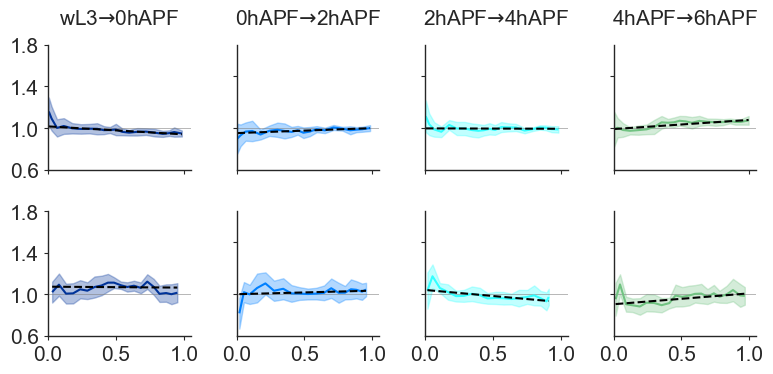

In [64]:
#plotting

rois = ['outDV', 'DV']

nbcols = len(devstage_combinations)
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                    figsize = (2*nbcols, 2*nbrows)
                    )
main_ax = fig.add_subplot(111, frameon=False)




for i in range(len(rois)):
    roi = rois[i]

    for j in range(len(devstage_combinations)):

        devstage_init = devstage_combinations.loc[j,'devstage_init']
        devstage_final = devstage_combinations.loc[j,'devstage_final']        
        print(devstage_final)
        ax = axs[i,j]
        ax.axhline(1, linestyle = '-', linewidth = '0.4', color ='grey')
        label_init = devstage_init
        label_final = devstage_final
        title = label_init + r'$ \to $' + label_final
        axs[0,j].set_title(title, fontsize = 15, pad = 15)
        axs[i,0].set_yticks(np.arange(0.6,2, 0.4))
        axs[1,j].set_xticks([0.0,0.5,1.0])
        axs[i,1].set_yticklabels(['','','',])
        axs[i,2].set_yticklabels(['','','',])
        axs[i,3].set_yticklabels(['','','',])
        axs[0,j].set_xticklabels(['','','',])

        

        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
        data = diff_stat.query(query_str)
        x_col = 'ref_pathlength_scaled_beta_mean'
        y_col = prop + '_diff'
        ax.plot(data[x_col], data[prop +'_diff_mean'], color = colors[devstage_final])
        ax.fill_between(x = data[x_col], y1 = data[prop +'_diff_mean'] - data[prop +'_diff_std'], y2 = data[prop +'_diff_mean'] + data[prop +'_diff_std'],color = colors[devstage_final], alpha = 0.3)
        ax.plot(data[x_col], data['fit_' + prop +'_diff'], color = 'black', linestyle = '--')
        ax.tick_params(axis='both', which='major', labelsize=15)
        # axs[1,j].set_xlabel(xlabel, fontsize = 15,labelpad=4, rotation = 'horizontal')

        ax.set_ylim(0.6,1.8)
        ax.set_xlim(0,1.05)

    
    
    main_ax.set_yticks([])
    main_ax.set_xticks([])
    fig.tight_layout()
    
    plt.savefig(dataout + genotype + prop  + '_' + '_std_lamdavsP_stepwise_wFit.pdf',dpi = 600,bbox_inches = 'tight')



In [65]:
diff_stat

,k_beta,N_beta_mean,N_beta_std,ref_pathlength_scaled_beta_mean,ref_pathlength_scaled_beta_std,exp_signed_Qnorm_diff_mean,exp_signed_Qnorm_diff_std,exp_signed_Qnorm_beta_mean,exp_signed_Qnorm_beta_std,exp_signed_Qnorm_alpha_mean,exp_signed_Qnorm_alpha_std,roi,devstage_init,devstage_final,fit_exp_signed_Qnorm_diff,fit_exp_signed_Qnorm_coeffs
0,0,1.000000,0.000000,0.005731,0.000000,1.158659,0.134844,0.918234,0.079645,1.056350,0.083376,outDV,wL3,0hAPF,1.015494,"[-0.07677111623301817, 1.0159336426068148]"
1,1,4.678571,0.434685,0.026282,0.002383,1.091355,0.115523,0.973933,0.074984,1.056958,0.077412,outDV,wL3,0hAPF,1.013916,"[-0.07677111623301817, 1.0159336426068148]"
2,2,12.251903,1.785715,0.066034,0.008934,1.001358,0.083028,1.016241,0.030688,1.016677,0.077879,outDV,wL3,0hAPF,1.010864,"[-0.07677111623301817, 1.0159336426068148]"
3,3,22.638095,1.802753,0.115583,0.008061,1.019587,0.075750,1.015978,0.038740,1.034412,0.065339,outDV,wL3,0hAPF,1.007060,"[-0.07677111623301817, 1.0159336426068148]"
4,4,37.577937,2.752045,0.177544,0.010446,0.997595,0.049801,1.012371,0.022997,1.009384,0.043599,outDV,wL3,0hAPF,1.002303,"[-0.07677111623301817, 1.0159336426068148]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,16,107.832120,6.172242,0.780300,0.044664,0.976907,0.057327,1.105835,0.032716,1.079275,0.052504,DV,4hAPF,6hAPF,0.986848,"[0.10495089134526024, 0.9049552288404358]"
156,17,115.085799,6.321848,0.832789,0.045746,1.000002,0.082310,1.063309,0.060925,1.064857,0.062482,DV,4hAPF,6hAPF,0.992357,"[0.10495089134526024, 0.9049552288404358]"
157,18,121.498328,6.674622,0.879192,0.048299,1.041609,0.107249,1.028126,0.076837,1.061653,0.082935,DV,4hAPF,6hAPF,0.997227,"[0.10495089134526024, 0.9049552288404358]"
158,19,128.859907,7.552490,0.932462,0.054652,0.989605,0.109681,1.064463,0.068151,1.052313,0.091978,DV,4hAPF,6hAPF,1.002818,"[0.10495089134526024, 0.9049552288404358]"


In [66]:
#function to compare between pairs of stages

compareStepwise = False
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[1:-1]})



# prop = 'area'

# [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide-sqrt',
#                                                    devstage_combinations=devstage_combinations, 
#                                                    fit_param = 'ref_pathlength_scaled_beta_mean'
#                                                   )

prop = 'exp_signed_Qnorm'

[diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = 'divide',
                                                   devstage_combinations=devstage_combinations,
                                                   fit_param='ref_pathlength_scaled_beta_mean',
                                              )



In [67]:
prop

'exp_signed_Qnorm'

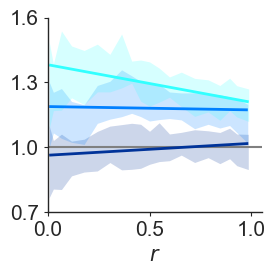

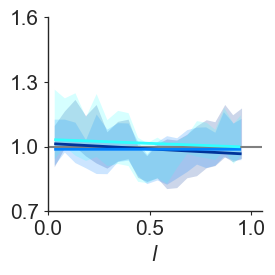

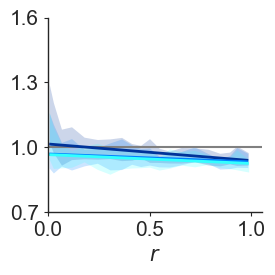

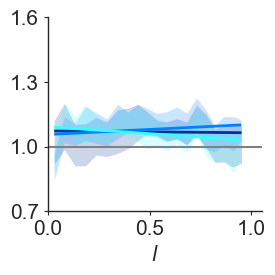

In [79]:
#plotting

#plotting
rois = ['outDV', 'DV']
# this is targeted to latex content
nbcols = 1
nbrows = 1
compareStepwise = False
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[1:-1]})

for prop in ['area','exp_signed_Qnorm']:
    if prop == 'area':
        # operation = 'divide'
        operation = 'divide-sqrt'

    elif prop == 'exp_signed_Qnorm':
        operation = 'divide'

    [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = operation,
                                                    devstage_combinations=devstage_combinations,
                                                    fit_param='ref_pathlength_scaled_beta_mean',
                                                )
    x_col = 'ref_pathlength_scaled_beta_mean'
    xlabel = r'$p$'
    for i in range(len(rois)):
        fig,ax = plt.subplots(figsize = (3, 3)
                        )
        roi = rois[i]
        if roi == 'DV': 
            style = '--' 
            xlabel = r'$l$'
            
        else:
            style = '-' 
            xlabel = r'$r$'
        style = '-' 
        ax.axhline(1, linestyle = '-', color ='grey')
        for j in range(len(devstage_combinations)):

            devstage_init = devstage_combinations.loc[j,'devstage_init']
            devstage_final = devstage_combinations.loc[j,'devstage_final']        
            
            ax.set_yticks(np.arange(0.7,2, 0.3))
            ax.set_xticks([0.0,0.5,1.0])
            query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'

            data = diff_stat.query(query_str)
            ax.fill_between(x = data[x_col], y1 = data[prop +'_diff_mean'] - data[prop +'_diff_std'], y2 = data[prop +'_diff_mean'] + data[prop +'_diff_std'],color = colors[devstage_final], alpha = 0.2, linewidth = 0)
            ax.plot(data[x_col], data['fit_' + prop +'_diff'], color = colors[devstage_final], linestyle = style, linewidth = 2)
            ax.tick_params(axis='both', which='major', labelsize=15)
            
            ax.set_xlabel(xlabel, fontsize = 15,labelpad=4, rotation = 'horizontal')

            ax.set_ylim(0.7,1.6)
            ax.set_xlim(0,1.05)
        fig.tight_layout()
             
        plt.savefig(dataout + genotype + prop + roi  + '_' + '_std_lamdavsP_cumulative_wFit_eversion.pdf',dpi = 600,bbox_inches = 'tight')



/Users/fuhrmann/workspace/wdeversion_paper//CurvedTM/curvedtm/prop_comparison_methods.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disc_devstage.loc[:,'k_dist'] = df_disc_devstage['k_dist'].values - min(df_disc_devstage['k_dist'])
/Users/fuhrmann/workspace/wdeversion_paper//CurvedTM/curvedtm/prop_comparison_methods.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disc_devstage.loc[:,'k_dist'] = df_disc_devstage['k_dist'].values - min(df_disc_devstage['k_dist'])
/Users/fuhrmann/workspace/

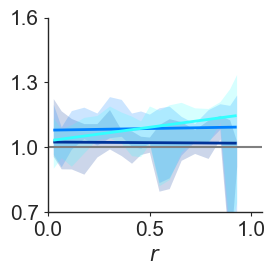

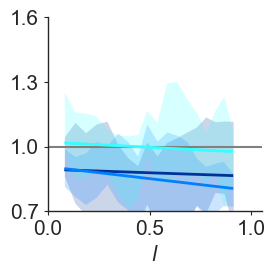

In [76]:

#plotting

rois = ['outDV', 'DV']

nbcols = 1
nbrows = 1

compareStepwise = False
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[1:-1]})


[k_N_alldiscs, k_N_mean] = Ntools.analyze_ring_cell_numbers(df, devstages = devstages)
[k_diff, k_diff_stat] = Ntools.get_k_differences(k_N_alldiscs, devstage_combinations = devstage_combinations, rois = rois, fit_param = 'ref_pathlength_scaled_beta_mean', N_ref_pathlength_dict = k_scaled_dist_dict)

prop = "lambda_rearrangement"
fit_lambdas_df = Ntools.compile_fit_lambdas_for_sim(k_diff_stat, prop = prop, lambda_name = "lambda_rearrangement_coeffs")

x_col = 'ref_pathlength_scaled_beta_mean'

for i in range(len(rois)):
    fig,ax = plt.subplots(figsize = (3, 3)
                    )
    roi = rois[i]
    if roi == 'DV': 
        style = '-' 
        xlabel = r'$l$'
        
    else:
        style = '-' 
        xlabel = r'$r$'
                
    ax.axhline(1, linestyle = '-', color ='grey')
    for j in range(len(devstage_combinations)):

        devstage_init = devstage_combinations.loc[j,'devstage_init']
        devstage_final = devstage_combinations.loc[j,'devstage_final']        
        
        ax.set_yticks(np.arange(0.7,2, 0.3))
        ax.set_xticks([0.0,0.5,1.0])
        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
    
        data = k_diff_stat.query(query_str)
        ax.fill_between(x = data[x_col], y1 = data[prop + '_mean'] - data[prop +'_std'], y2 = data[prop +'_mean'] + data[prop +'_std'],color = colors[devstage_final], alpha = 0.2, linewidth = 0)
        ax.plot(data[x_col], data['fit_' + prop], color = colors[devstage_final], linestyle = style, linewidth = 2)
        ax.tick_params(axis='both', which='major', labelsize=15)
        
        ax.set_xlabel(xlabel, fontsize = 15,labelpad=4, rotation = 'horizontal')

        ax.set_ylim(0.7,1.6)
        ax.set_xlim(0,1.05)
    fig.tight_layout()
    
    plt.savefig(dataout + genotype + prop + roi  + '_' + '_std_lamdavsP_cumulative_wFit_eversion.pdf',dpi = 600,bbox_inches = 'tight')



In [121]:
df_pool_k

,devstage,region,discName,k_dist,area,neighbour_number,elongation_tensor_norm_max,Qrr_geom_inPlane,Qphiphi,Qnn,Qrphi,Qrn,Qphin,countInBin,cumcount,k_dist_pathlength,pathlength_scaled,Qnorm,exp_signed_Qnorm,ref_pathlength_scaled
0,0hAPF,DV,20200706_ecadGFPnbG4myoVI_whitePupa_disc1_DV,0,3.061568,5.000000,0.249922,0.204270,-0.203653,-0.000418,-0.123538,0.009105,-0.003149,2.000000,2.000000,0.000000,0.000000,0.238722,1.269625,0.014669
1,0hAPF,DV,20200706_ecadGFPnbG4myoVI_whitePupa_disc1_DV,1,6.454322,6.000000,0.315932,-0.032773,0.033256,-0.000493,-0.039746,-0.002781,0.002546,3.000000,5.000000,2.334126,0.038969,0.051515,0.949789,0.036672
2,0hAPF,DV,20200706_ecadGFPnbG4myoVI_whitePupa_disc1_DV,2,5.459215,6.250000,0.264645,0.153475,-0.151963,-0.001378,-0.149287,-0.000491,0.002735,4.000000,9.000000,5.093696,0.085041,0.214105,1.238753,0.066010
3,0hAPF,DV,20200706_ecadGFPnbG4myoVI_whitePupa_disc1_DV,3,5.531461,5.750000,0.369078,0.152368,-0.151011,-0.001124,-0.131496,-0.003013,0.003220,8.000000,17.000000,8.005867,0.133661,0.201264,1.222947,0.124686
4,0hAPF,DV,20200706_ecadGFPnbG4myoVI_whitePupa_disc1_DV,4,5.282776,5.909091,0.252994,0.046117,-0.045295,-0.000849,-0.060652,-0.003922,0.001688,11.000000,28.000000,11.065548,0.184743,0.076194,1.079172,0.205364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,wL3,outDV,20210125_ecadGFPnbG4myoVI_upcrawling_disc2_outDV,15,7.277205,5.944954,0.151530,0.016834,-0.016493,-0.000292,0.002215,0.000760,0.000720,54.541284,439.990826,46.851344,0.777962,0.016980,1.017124,0.793992
1287,wL3,outDV,20210125_ecadGFPnbG4myoVI_upcrawling_disc2_outDV,16,7.617043,6.017857,0.174884,0.031927,-0.031452,-0.000520,-0.000249,0.001271,-0.000323,56.017857,496.187500,50.065899,0.831340,0.031928,1.032443,0.849431
1288,wL3,outDV,20210125_ecadGFPnbG4myoVI_upcrawling_disc2_outDV,17,7.728023,5.896000,0.168633,0.022658,-0.022292,-0.000267,-0.016965,0.000471,-0.000062,62.504000,559.144000,54.010727,0.896843,0.028306,1.028710,0.896536
1289,wL3,outDV,20210125_ecadGFPnbG4myoVI_upcrawling_disc2_outDV,18,7.984222,6.050000,0.185940,0.019634,-0.019093,-0.000489,0.012569,-0.000807,-0.000151,60.000000,601.000000,56.659511,0.940826,0.023312,1.023586,0.926744


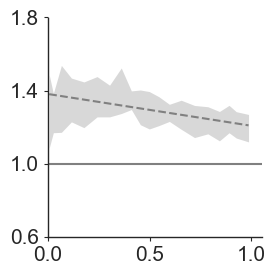

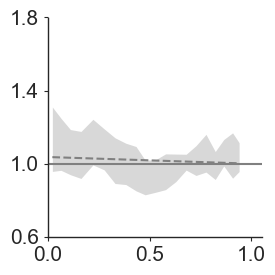

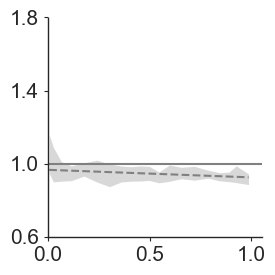

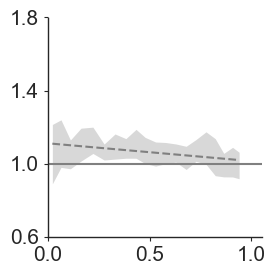

In [116]:

compareStepwise = False
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[1:-1]})


for prop in ['area','exp_signed_Qnorm']:
    if prop == 'area':
        operation = 'divide-sqrt'

    elif prop == 'exp_signed_Qnorm':
        operation = 'divide'

    [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = operation,
                                                    devstage_combinations=devstage_combinations,
                                                    fit_param='ref_pathlength_scaled_beta_mean',
                                                )


    rois = ['outDV', 'DV']
    for i in range(len(rois)):
        fig,ax = plt.subplots(figsize = (3,3)
                        )
        roi = rois[i]
        ax.axhline(1, linestyle = '-', color ='grey')

        devstage_init = 'wL3'
        devstage_final = '4hAPF' 

        ax.set_yticks(np.arange(0.6,2, 0.4))
        ax.set_xticks([0.0,0.5,1.0])
        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
        x_col = 'ref_pathlength_scaled_beta_mean'

        # data = diff.query(query_str)
        # ax.scatter(data['ref_pathlength_scaled_beta'], data[prop +'_diff'], color = colors[devstage_final], marker ='.', alpha =0.1)

        data = diff_stat.query(query_str)
        ax.fill_between(x = data[x_col], y1 = data[prop +'_diff_mean'] - data[prop +'_diff_std'], y2 = data[prop +'_diff_mean'] + data[prop +'_diff_std'],color = 'gray', alpha = 0.3, linewidth = 0)
        ax.plot(data[x_col], data['fit_' + prop +'_diff'], color = 'gray', linestyle = '--')
        ax.tick_params(axis='both', which='major', labelsize=15)
        
        # axs.set_xlabel(xlabel, fontsize = 15,labelpad=4, rotation = 'horizontal')

        ax.set_ylim(0.6,1.8)
        ax.set_xlim(0,1.05)
        fig.tight_layout()
        
        plt.savefig(dataout + genotype + prop + roi  + '_' + '_std_lamdavsP_wFit_wl3_4hAPF.pdf',dpi = 600,bbox_inches = 'tight')

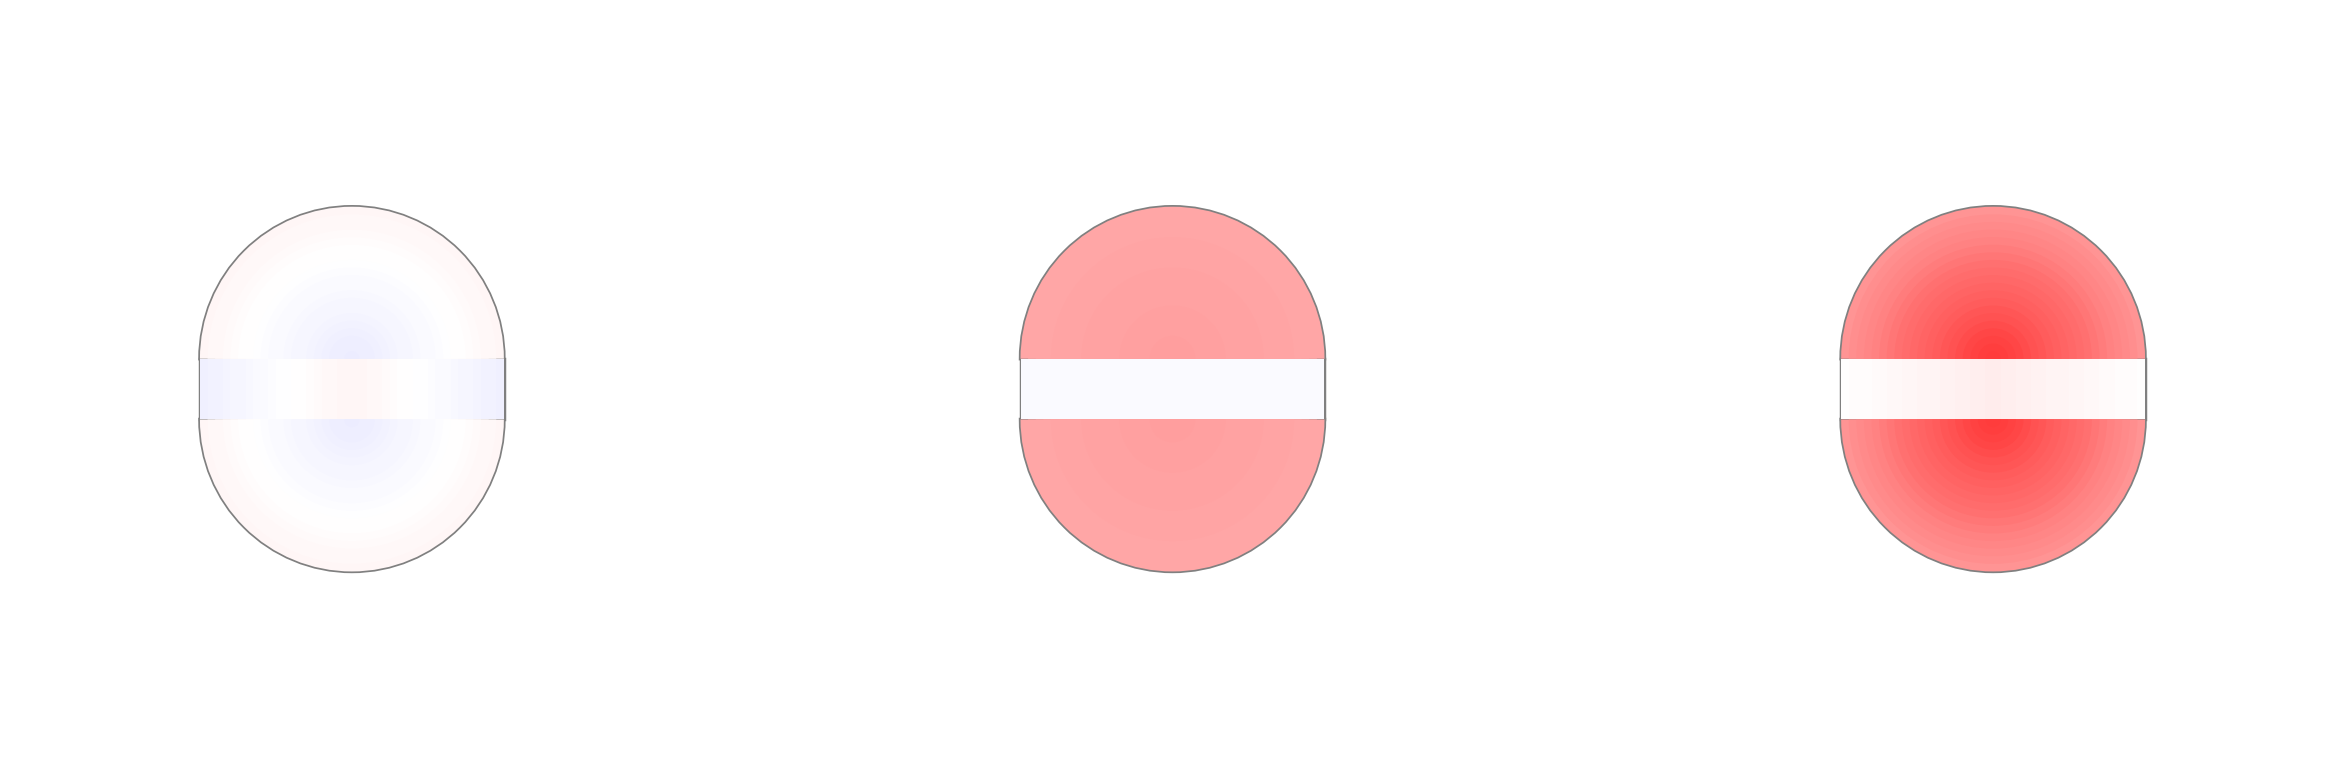

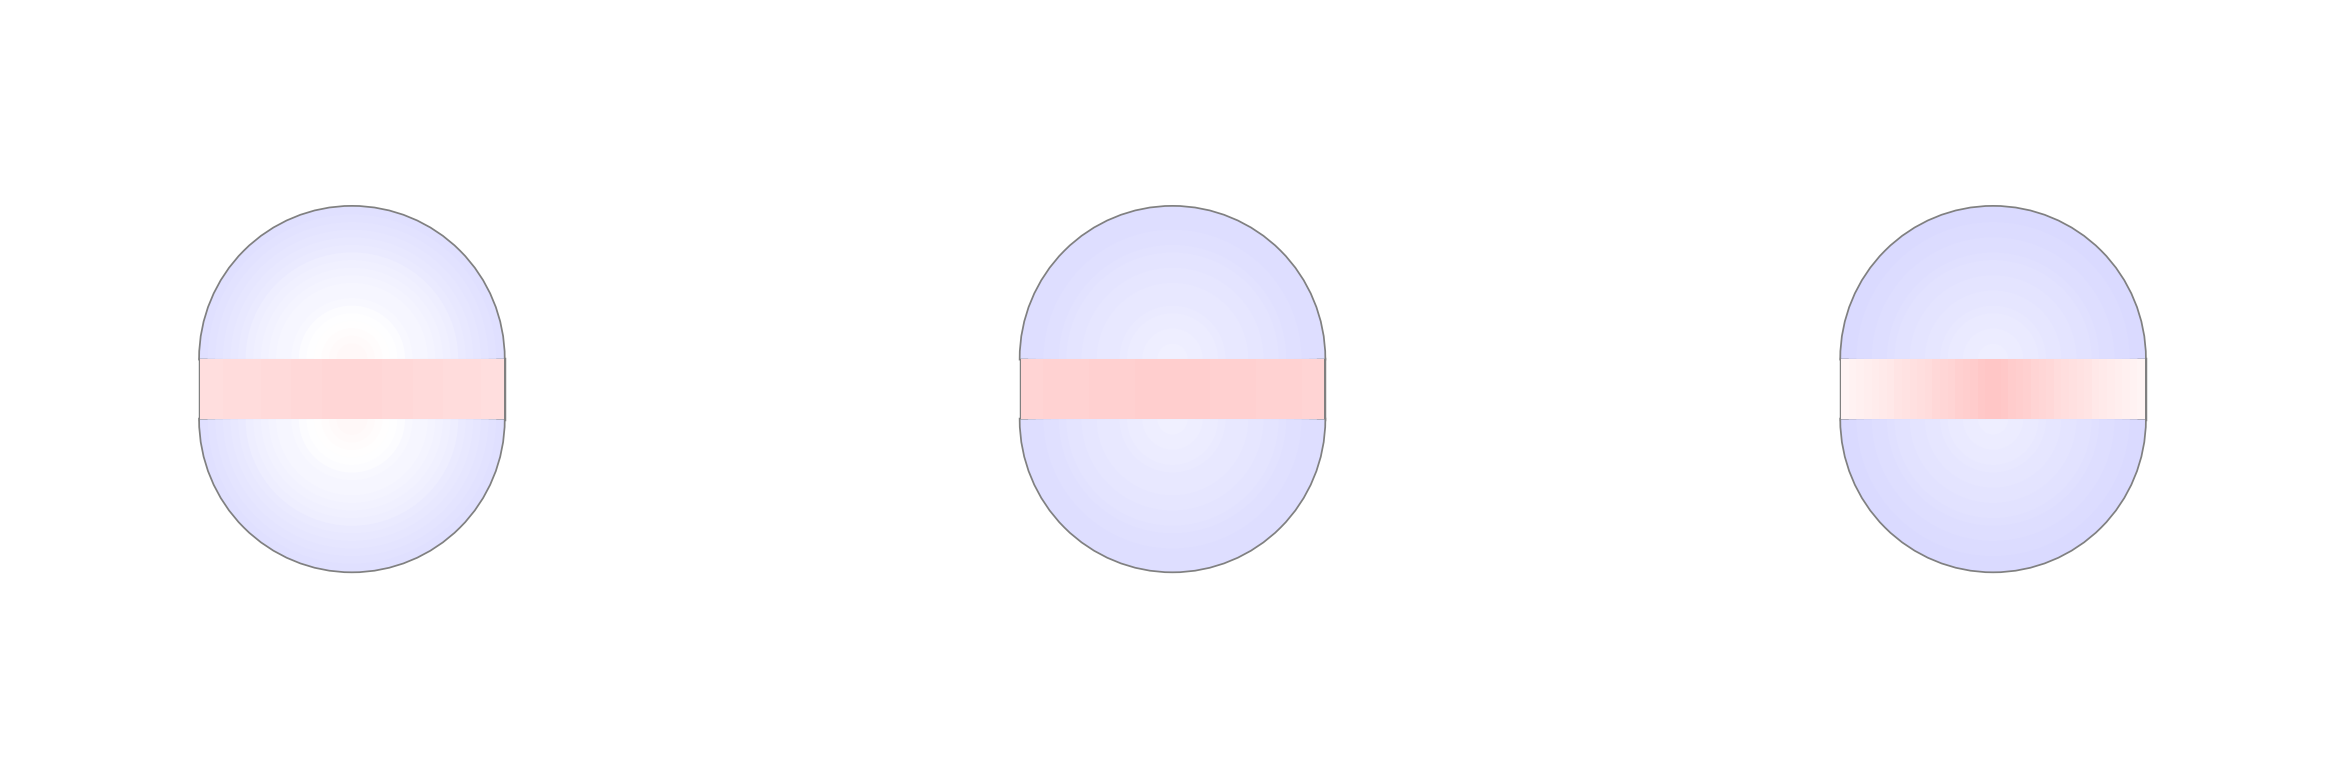

In [117]:
#Visualize Geometry
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm

############################ params
cmap = cm.bwr

climMin = 0.5
climMax = 1.5
compareStepwise = False
fit = True

if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
    changes = 'stepwise'
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[1:-1]})
    changes = 'cumulative'


for prop in ['area','exp_signed_Qnorm']:

    if prop == 'area':
        operation = 'divide-sqrt'

    elif prop == 'exp_signed_Qnorm':
        operation = 'divide'

    [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = operation,
                                                    devstage_combinations=devstage_combinations,
                                                    fit_param='ref_pathlength_scaled_beta_mean',
                                                )
    prop2 = prop +'_diff_mean'

    fitline = ''
    if fit:
        prop2 = 'fit_' + prop +'_diff'
        fitline = '_fit'

    fig, ax = plt.subplots(1,len(devstage_combinations),figsize=(30, 10))
    for j in range(len(devstage_combinations)):
        
        devstage_init = devstage_combinations.loc[j,'devstage_init']
        devstage_final = devstage_combinations.loc[j,'devstage_final']   
        

        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '")'
        data = diff_stat.query(query_str)
        #data[['k_beta','fit_exp_signed_Qnorm_diff','roi']]
        # data[['k_beta','exp_signed_Qnorm_diff_mean','roi']]
        data = data.sort_values(['k_beta'],ascending=False)

        values = data.loc[data['roi']=='outDV'][prop2].values
        valuesDV = data.loc[data['roi']=='DV'][prop2].values

        from matplotlib.collections import PatchCollection
        #ax.set_aspect('equal')

        patches1 = []
        patches2 = []
        patches3 = []
        patches4 = []
        angle = 0
        scaling = 0.019
        scaling = 0.01
        theta1, theta2 = angle, angle + 180
        resolution = 100

        climDVMin = climMin
        climDVMax =  climMax

        for i in range(len(values),0,-1):
            radius= i*scaling
            w1 = Wedge((0, 0.04), radius, theta1, theta2, lw=2)
            for wedge in [w1]:
                patches1.append(wedge)
        p1 = PatchCollection(patches1, alpha=1, cmap=cmap)
        colorsDorsal = values
        p1.set_array(colorsDorsal)
        p1.set_clim([climMin, climMax])


        for i in range(len(values),0,-1):
            radius= i*scaling
            w2 = Wedge((0, -0.04), radius, theta2, theta1, lw=2)
            for wedge in [w2]:
                patches2.append(wedge)
        p2 = PatchCollection(patches2, alpha=1, cmap=cmap)
        colorsVentral = values
        p2.set_array(colorsVentral)
        p2.set_clim([climMin, climMax])
        
        for i in range(len(values),0,-1):
            positionX = 0
            polygon = Rectangle((positionX, -0.04), width=scaling*i, height=0.08, angle=0.0) 
            patches3.append(polygon)
            p3 = PatchCollection(patches3, cmap=cmap, ec = 'grey', linewidth = 0)
            colorsDV = valuesDV
            p3.set_array(colorsDV)
            p3.set_clim([climDVMin, climDVMax])
            
        for i in range(len(values),0,-1):
            positionX = -(i*scaling)
            polygon = Rectangle((positionX, -0.04), width=scaling, height=0.08, angle=0.0) 
            patches4.append(polygon)
            p4 = PatchCollection(patches4, cmap=cmap, ec = 'grey', linewidth = 0)
            colorsDV = valuesDV
            p4.set_array(colorsDV)
            p4.set_clim([climDVMin, climDVMax])
        col = j 
        ax[col].set_aspect('equal')
        p5 = Rectangle((-len(values)*scaling,-0.04), width=len(values)*scaling*2, height=0.08, angle=0.0, linewidth=2.5, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p5)
        p6 = Wedge((0,+0.04),len(values)*scaling, theta1, theta2,  linewidth=2.5, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p6)
        p7 = Wedge((0,-0.04),len(values)*scaling, theta2, theta1,  linewidth=2.5, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p7)

        
        ax[col].add_collection(p1)
        ax[col].add_collection(p2)
        ax[col].add_collection(p3)
        ax[col].add_collection(p4)

        ax[col].set_xlim(-0.45,0.45)
        ax[col].set_ylim(-0.5,0.5)
        ax[col].set_axis_off()

    plt.savefig(dataout + genotype + prop  + '_' + prop2 + '_' + 'changes_'+ changes + '_geometry_all'+ fitline + '.pdf',dpi = 300,bbox_inches = 'tight')


In [118]:
df_pool_k

,devstage,region,discName,k_dist,area,neighbour_number,elongation_tensor_norm_max,Qrr_geom_inPlane,Qphiphi,Qnn,Qrphi,Qrn,Qphin,countInBin,cumcount,k_dist_pathlength,pathlength_scaled,Qnorm,exp_signed_Qnorm,ref_pathlength_scaled
0,0hAPF,DV,20200706_ecadGFPnbG4myoVI_whitePupa_disc1_DV,0,3.061568,5.000000,0.249922,0.204270,-0.203653,-0.000418,-0.123538,0.009105,-0.003149,2.000000,2.000000,0.000000,0.000000,0.238722,1.269625,0.014669
1,0hAPF,DV,20200706_ecadGFPnbG4myoVI_whitePupa_disc1_DV,1,6.454322,6.000000,0.315932,-0.032773,0.033256,-0.000493,-0.039746,-0.002781,0.002546,3.000000,5.000000,2.334126,0.038969,0.051515,0.949789,0.036672
2,0hAPF,DV,20200706_ecadGFPnbG4myoVI_whitePupa_disc1_DV,2,5.459215,6.250000,0.264645,0.153475,-0.151963,-0.001378,-0.149287,-0.000491,0.002735,4.000000,9.000000,5.093696,0.085041,0.214105,1.238753,0.066010
3,0hAPF,DV,20200706_ecadGFPnbG4myoVI_whitePupa_disc1_DV,3,5.531461,5.750000,0.369078,0.152368,-0.151011,-0.001124,-0.131496,-0.003013,0.003220,8.000000,17.000000,8.005867,0.133661,0.201264,1.222947,0.124686
4,0hAPF,DV,20200706_ecadGFPnbG4myoVI_whitePupa_disc1_DV,4,5.282776,5.909091,0.252994,0.046117,-0.045295,-0.000849,-0.060652,-0.003922,0.001688,11.000000,28.000000,11.065548,0.184743,0.076194,1.079172,0.205364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,wL3,outDV,20210125_ecadGFPnbG4myoVI_upcrawling_disc2_outDV,15,7.277205,5.944954,0.151530,0.016834,-0.016493,-0.000292,0.002215,0.000760,0.000720,54.541284,439.990826,46.851344,0.777962,0.016980,1.017124,0.793992
1287,wL3,outDV,20210125_ecadGFPnbG4myoVI_upcrawling_disc2_outDV,16,7.617043,6.017857,0.174884,0.031927,-0.031452,-0.000520,-0.000249,0.001271,-0.000323,56.017857,496.187500,50.065899,0.831340,0.031928,1.032443,0.849431
1288,wL3,outDV,20210125_ecadGFPnbG4myoVI_upcrawling_disc2_outDV,17,7.728023,5.896000,0.168633,0.022658,-0.022292,-0.000267,-0.016965,0.000471,-0.000062,62.504000,559.144000,54.010727,0.896843,0.028306,1.028710,0.896536
1289,wL3,outDV,20210125_ecadGFPnbG4myoVI_upcrawling_disc2_outDV,18,7.984222,6.050000,0.185940,0.019634,-0.019093,-0.000489,0.012569,-0.000807,-0.000151,60.000000,601.000000,56.659511,0.940826,0.023312,1.023586,0.926744


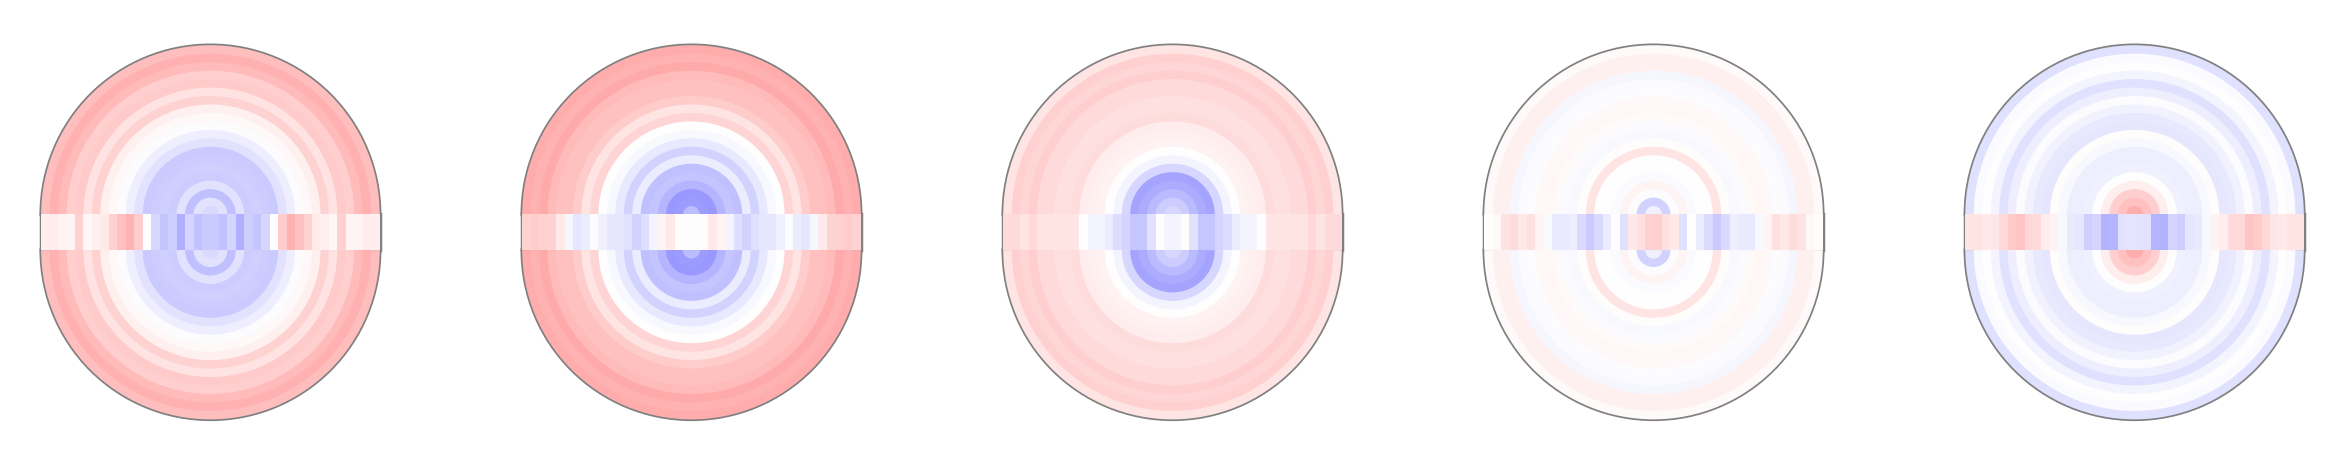

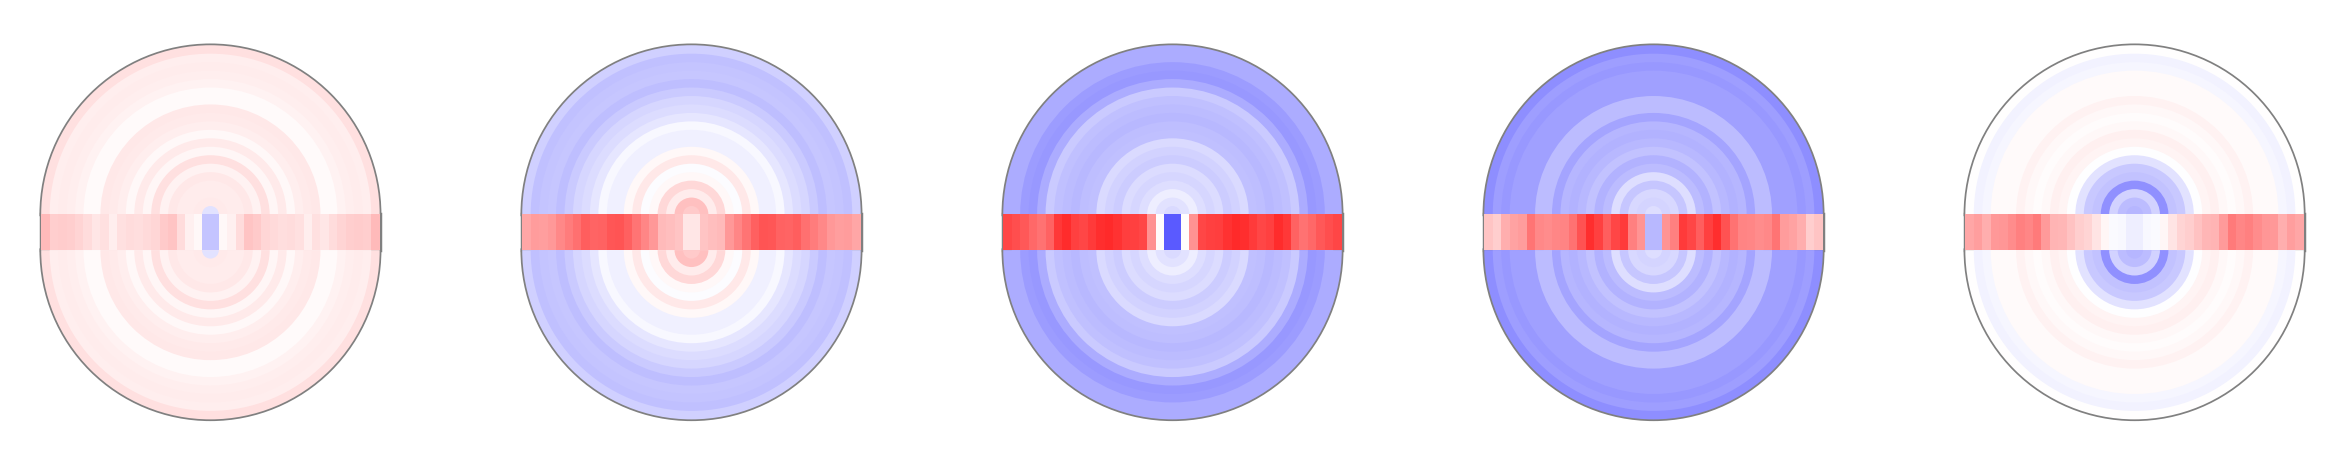

In [122]:
#Visualize Geometry
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm

############################ params
cmap = cm.bwr


compareStepwise = False
fit = False

if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
    changes = 'stepwise'
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[0:]})
    changes = 'cumulative'


for prop in ['area','Qrr_geom_inPlane']:

    if prop == 'area':
        operation = 'divide-sqrt'


    elif prop == 'exp_signed_Qnorm':
        operation = 'divide'

    elif prop == 'Qrr_geom_inPlane':
        operation = 'divide'

    [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = operation,
                                                    devstage_combinations=devstage_combinations,
                                                    fit_param='ref_pathlength_scaled_beta_mean',
                                                )
    prop2 = prop +'_alpha_mean'

    fitline = ''
    if fit:
        prop2 = 'fit_' + prop +'_diff'
        fitline = '_fit'

    fig, ax = plt.subplots(1,len(devstage_combinations),figsize=(30, 10))
    for j in range(len(devstage_combinations)):
        
        devstage_init = devstage_combinations.loc[j,'devstage_init']
        devstage_final = devstage_combinations.loc[j,'devstage_final']   
        

        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '")'
        data = diff_stat.query(query_str)
        #data[['k_beta','fit_exp_signed_Qnorm_diff','roi']]
        # data[['k_beta','exp_signed_Qnorm_diff_mean','roi']]
        data = data.sort_values(['k_beta'],ascending=False)

        values = data.loc[data['roi']=='outDV'][prop2].values
        valuesDV = data.loc[data['roi']=='DV'][prop2].values



        from matplotlib.collections import PatchCollection
        #ax.set_aspect('equal')

        patches1 = []
        patches2 = []
        patches3 = []
        patches4 = []
        angle = 0
        scaling = 0.019
        # scaling = 0.01
        theta1, theta2 = angle, angle + 180
        resolution = 100

        # climDVMin = climMin
        # climDVMax =  climMax

        if prop == 'area':
            climMin = values.mean() *0.5
            climMax = values.mean() *1.5

            climDVMin = valuesDV.mean() *0.5
            climDVMax = valuesDV.mean() *1.5

        elif prop == 'exp_signed_Qnorm':
            climMin = 0.9
            climMax = 1.2

            climDVMin = climMin
            climDVMax =  climMax

        elif prop == 'Qrr_geom_inPlane':    
            climMin = -0.15
            climMax = 0.15

            climDVMin = climMin
            climDVMax =  climMax


        for i in range(len(values),0,-1):
            radius= i*scaling
            w1 = Wedge((0, 0.04), radius, theta1, theta2, lw=2)
            for wedge in [w1]:
                patches1.append(wedge)
        p1 = PatchCollection(patches1, alpha=1, cmap=cmap)
        colorsDorsal = values
        p1.set_array(colorsDorsal)
        p1.set_clim([climMin, climMax])


        for i in range(len(values),0,-1):
            radius= i*scaling
            w2 = Wedge((0, -0.04), radius, theta2, theta1, lw=2)
            for wedge in [w2]:
                patches2.append(wedge)
        p2 = PatchCollection(patches2, alpha=1, cmap=cmap)
        colorsVentral = values
        p2.set_array(colorsVentral)
        p2.set_clim([climMin, climMax])
        
        for i in range(len(values),0,-1):
            positionX = 0
            polygon = Rectangle((positionX, -0.04), width=scaling*i, height=0.08, angle=0.0) 
            patches3.append(polygon)
            p3 = PatchCollection(patches3, cmap=cmap, ec = 'grey', linewidth = 0)
            colorsDV = valuesDV
            p3.set_array(colorsDV)
            p3.set_clim([climDVMin, climDVMax])
            
        for i in range(len(values),0,-1):
            positionX = -(i*scaling)
            polygon = Rectangle((positionX, -0.04), width=scaling, height=0.08, angle=0.0) 
            patches4.append(polygon)
            p4 = PatchCollection(patches4, cmap=cmap, ec = 'grey', linewidth = 0)
            colorsDV = valuesDV
            p4.set_array(colorsDV)
            p4.set_clim([climDVMin, climDVMax])
        col = j 
        ax[col].set_aspect('equal')
        p5 = Rectangle((-len(values)*scaling,-0.04), width=len(values)*scaling*2, height=0.08, angle=0.0, linewidth=2.5, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p5)
        p6 = Wedge((0,+0.04),len(values)*scaling, theta1, theta2,  linewidth=2.5, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p6)
        p7 = Wedge((0,-0.04),len(values)*scaling, theta2, theta1,  linewidth=2.5, edgecolor='grey', facecolor='none') 
        ax[col].add_patch(p7)

        
        ax[col].add_collection(p1)
        ax[col].add_collection(p2)
        ax[col].add_collection(p3)
        ax[col].add_collection(p4)

        ax[col].set_xlim(-0.45,0.45)
        ax[col].set_ylim(-0.5,0.5)
        ax[col].set_axis_off()

    plt.savefig(dataout + genotype + prop  + '_' + prop2 + '_' + '_geometry_all'+ fitline + '.pdf',dpi = 300,bbox_inches = 'tight')


0
1
0
1


/Users/fuhrmann/workspace/wdeversion_paper//CurvedTM/curvedtm/prop_comparison_methods.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disc_devstage.loc[:,'k_dist'] = df_disc_devstage['k_dist'].values - min(df_disc_devstage['k_dist'])
/Users/fuhrmann/workspace/wdeversion_paper//CurvedTM/curvedtm/prop_comparison_methods.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_disc_devstage.loc[:,'k_dist'] = df_disc_devstage['k_dist'].values - min(df_disc_devstage['k_dist'])
/Users/fuhrmann/workspace/

0
1


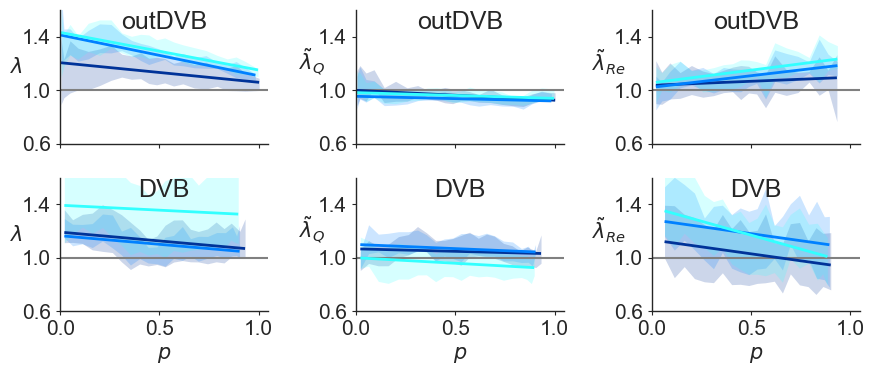

In [19]:



compareStepwise = False
if compareStepwise:
    devstage_combinations = pd.DataFrame({'devstage_init':devstages[0:len(devstages)-1], 'devstage_final':devstages[1:]})
else: 
    devstage_combinations = pd.DataFrame({'devstage_init':'wL3', 'devstage_final':devstages[1:-1]})

fig,axs = plt.subplots(2, 3,
                       figsize = (3*3, 2*2), layout='constrained'
                      )

# plt.rcParams['axes.titlepad'] = -40

for j in range (0,3):
    prop = ['area','exp_signed_Qnorm','lambda_rearrangement'][j]
    if prop in ['area','exp_signed_Qnorm']:
            
        if prop == 'area':
            operation = 'divide-sqrt'
            ylabel = r'${\lambda}$'

        elif prop == 'exp_signed_Qnorm':
            operation = 'divide'
            ylabel = r'$\tilde{\lambda}_{Q}$'

        [diff, diff_stat] = Ntools.get_prop_differences(df_pool_k, prop = prop,operation = operation,
                                                        devstage_combinations=devstage_combinations,
                                                        fit_param='ref_pathlength_scaled_beta_mean',
                                                    )
        prop = prop + '_diff'

        
    elif prop == 'lambda_rearrangement':

        [k_N_alldiscs, k_N_mean] = Ntools.analyze_ring_cell_numbers(df, devstages = devstages)
        [diff, diff_stat] = Ntools.get_k_differences(k_N_alldiscs, devstage_combinations = devstage_combinations, rois = rois, fit_param = 'ref_pathlength_scaled_beta_mean', N_ref_pathlength_dict = k_scaled_dist_dict)
        # fit_lambdas_df = Ntools.compile_fit_lambdas_for_sim(diff_stat, prop = prop, lambda_name = "lambda_rearrangement_coeffs")
        ylabel = r'$\tilde{\lambda}_{Re}$'

    x_col = 'ref_pathlength_scaled_beta_mean'
    xlabel = r'$p$'
    for i in range(len(rois)):
        print(i)

        roi = rois[i]
        style = '-' 
                    
        axs[i,j].axhline(1, linestyle = '-', color ='grey')
        axs[i,j].set_yticks(np.arange(0.6,1.8,0.4))
        axs[1,j].set_xlabel(xlabel)
        
        axs[0,j].set_xticklabels([])


        ax = axs[i,j]
        ax.set_title(roi + 'B', y=1.0, pad=-14)
        ax.set_xticks(np.arange(0,1,0.5))
        ax.set_xlim(0,1)
        ax.set_ylabel(ylabel,rotation = 0)

        for stage in range(len(devstage_combinations)):

            devstage_init = devstage_combinations.loc[stage,'devstage_init']
            devstage_final = devstage_combinations.loc[stage,'devstage_final']        
            
            ax.set_yticks(np.arange(0.6,2, 0.4))
            ax.set_xticks([0.0,0.5,1.0])
            query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
            data = diff_stat.query(query_str)
            ax.fill_between(x = data[x_col], y1 = data[prop + '_mean'] - data[prop +'_std'], y2 = data[prop +'_mean'] + data[prop +'_std'],color = colors[devstage_final], alpha = 0.2, linewidth = 0)
            ax.plot(data[x_col], data['fit_' + prop], color = colors[devstage_final], linestyle = style, linewidth = 2)
            ax.tick_params(axis='both', which='major', labelsize=15)
            
            # ax.set_xlabel(xlabel, fontsize = 15,labelpad=4, rotation = 'horizontal')

            ax.set_ylim(0.6,1.6)
            ax.set_xlim(0,1.05)
            
        
        fig.tight_layout()


        #axs[1,j].set_xlabel(xlabel, fontsize = 20,labelpad=4, rotation = 'horizontal')
    # axs[1,1].set_yticklabels(['','',''])    
    # axs[0,1].set_yticklabels(['','',''])    

    # main_ax.set_yticks([])
    # main_ax.set_xticks([])
    fig.tight_layout()

plt.savefig(dataout + genotype + '_changesallLambda_eversion.pdf',dpi = 600,bbox_inches = 'tight')